In [1]:
import Methods as Methods
import os
import platform
from datetime import *
import sys
import warnings
import psutil
import traceback
import csv
import math
import shutil 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import qsturng, psturng
import numpy as np
import numpy_indexed as npi
from pyopenms import *
import pandas as pd
import pingouin as pg
from hypothetical.descriptive import var
from scipy import stats, signal
from scipy.stats import zscore, t
from scipy.optimize import curve_fit
from scipy.integrate import quad, cumulative_trapezoid
from scipy.signal import find_peaks, peak_widths, welch, savgol_filter
from scipy.ndimage import gaussian_filter1d
import scikit_posthocs as sp
from itertools import combinations
import peakutils
import importlib
import time

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/michael/anaconda3/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Inputs

In [2]:
## If kernel dies repeatedly while trying to centroid, try running this code on a 
## 'primer' file to initialize OpenMS. Also note - OpenMS has a known issue running data stored
## on an external drive (https://github.com/OpenMS/OpenMS/issues/3598) - recommend to move data to local

# Methods.prime_OpenMS('C:\\Users\\Michael\\Dropbox (MIT)\\pyBinder\\Data\\Misc')   
Methods.prime_OpenMS('/Users/michael/Dropbox (MIT)/pyBinder/Data/Misc')   

In [3]:
########################### Inputs ########################################

prots = ['12ca5','ACE2']             # List of proteins in selection
prots.sort()                              # Alphabetizes all of the proteins for ease
inj_levels = ['High','Mid','Low']         # Indicate protein concentrations levels, uses first for statistical significance - list in descending order
inj_percs = [1,0.6,0.3]                 # Percentage bead loading used for variable concentrations
selection = '20240416 12ca5 vs ACE2 Retrospect'       # Name of selection, will be in folder name       
sel_cutoff = 1/len(prots)           # cutoff score for sequencing run
p_score_cutoff = 0.134
peak_RT = 45                              # Estimated peak elution time in seconds
peak_RT_search = 300                      # Width (in seconds) of peak max intensity search, gets divided by 2 for +-
peps_sec = 3                              # maximum amount of peptides that can coelute, for building inclusion list
n_reps = 3                                # Number of replicates per protein PER INJECTION LEVEL
lib_size = 13                             # Length of peptides used, including fixed residues
conc_lib_start = 1                        # Concentration per sequence of library used, fmol/member

TIME = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")                   # Gets current time to prevent duplicate folders        
parent_dir = '/Users/michael/Dropbox (MIT)/pyBinder/Data/ACE2 vs 12ca5'
refname = 'BeadsOnly'                                                    # String in names of negative control files
folder = selection + ' ' + TIME                                          # Name of new folder to save output
data_dir = os.path.join(parent_dir,folder)                               # New folder to store centroided data
save_dir = os.path.join(parent_dir,folder)                               # If data is already centroided, use this folder 
                                                                         #    to save useful output
default_thresh = 5E4                                                     # Threshold of peak detection (ion counts), default 5e4
area_limit = 1E4                                                         # Area threshold for reporting, default 1e5
sel_minqual = 0.6                                                 # Selectivity score threshold for reporting
gradient_time = 120                                                       # Total time of gradient in minutes
peps_min = 10                                                            # Estimated number of peptides that can be sequenced per second
LOD = 1.5e4                                                              # Number of replicates per protein
centroided = False                                                       # Will skip the centroiding step if True
check_data = True                                                        # Will skip the TIC and 2D plotting if False, prints out TIC otherwise
full_out = True                                                          # Will print all features found for each protein
sortby_selscore = True                                                   # Sort only using selectivity score, use CDE as filter
variable_loading = False                                                  # Did you utilize a concentration series of protein loading for Selectivity? 
nr_EICs = 5
centroid_dir = '/Volumes/Michael Lee/Lumos_Data/20240330 - 362-058 12ca5 vs WDR5 X12K/20240331 12ca5 vs WDR5 X12K 2024_03_31-11_32_19_PM/centroided'  # If using pre-centroided data, put directory here (otherwise put None)
sub_EICs = False                                                         # Do additional EICs based only on Selectivity score
RT_start = 3                                                             # Method time for when MS turns on, mins
elute_window = 10                                                        # Time window for inclusion list search and EICs, mins

## Directory and reference setup

In [4]:
PRTC_check = False       
do_second_filter = True                                                  # Applies minimum and maximum mass filter based on peptide length compared to a pure Gly or pure Trp peptide

Methods.sys_checks(parent_dir,prots,centroided,sel_cutoff,
                   p_score_cutoff,peak_RT_search,peps_sec,n_reps,nr_EICs,LOD,True)
png_dir,PRTC_dir,results_dir, misc_dir = Methods.Setup().directory_setup(parent_dir,folder,save_dir,
                                                                       prots,centroided,PRTC_check)
Methods.Setup().export_inputs(save_dir,prots,selection,sel_cutoff,p_score_cutoff,peak_RT,peak_RT_search,peps_sec,n_reps,
                             lib_size,conc_lib_start,
                             default_thresh,area_limit,sel_minqual,gradient_time,peps_min,LOD,centroided,
                             centroid_dir,check_data,full_out,nr_EICs,sub_EICs,
                             RT_start,elute_window)
PRTC_mass_round = 0

RAW files found to analyze: ['256-092_12ca5-1.raw', '256-092_12ca5-2.raw', '256-092_12ca5-3.raw', '256-092_ACE2-1.raw', '256-092_ACE2-2.raw', '256-092_ACE2-3.raw']
Inputs exported to: /Users/michael/Dropbox (MIT)/pyBinder/Data/ACE2 vs 12ca5/20240416 12ca5 vs ACE2 Retrospect 2024_04_16-05_20_17_PM/Inputs.txt


## Data centroiding and checks

In [5]:
data_dir = Methods.Setup().data_centroiding(centroided,parent_dir,folder,PRTC_dir,
                                            data_dir,prots,centroid_dir = centroid_dir, refname = refname)

256-092_12ca5-High1.mzML loaded
peaks picked
another one done
1
256-092_12ca5-High2.mzML loaded
peaks picked
another one done
2
256-092_12ca5-High3.mzML loaded
peaks picked
another one done
3
256-092_ACE2-High1.mzML loaded
peaks picked
another one done
4
256-092_ACE2-High2.mzML loaded
peaks picked
another one done
5
256-092_ACE2-High3.mzML loaded
peaks picked
another one done
6


loaded
Fifth percentile = 16585655.5


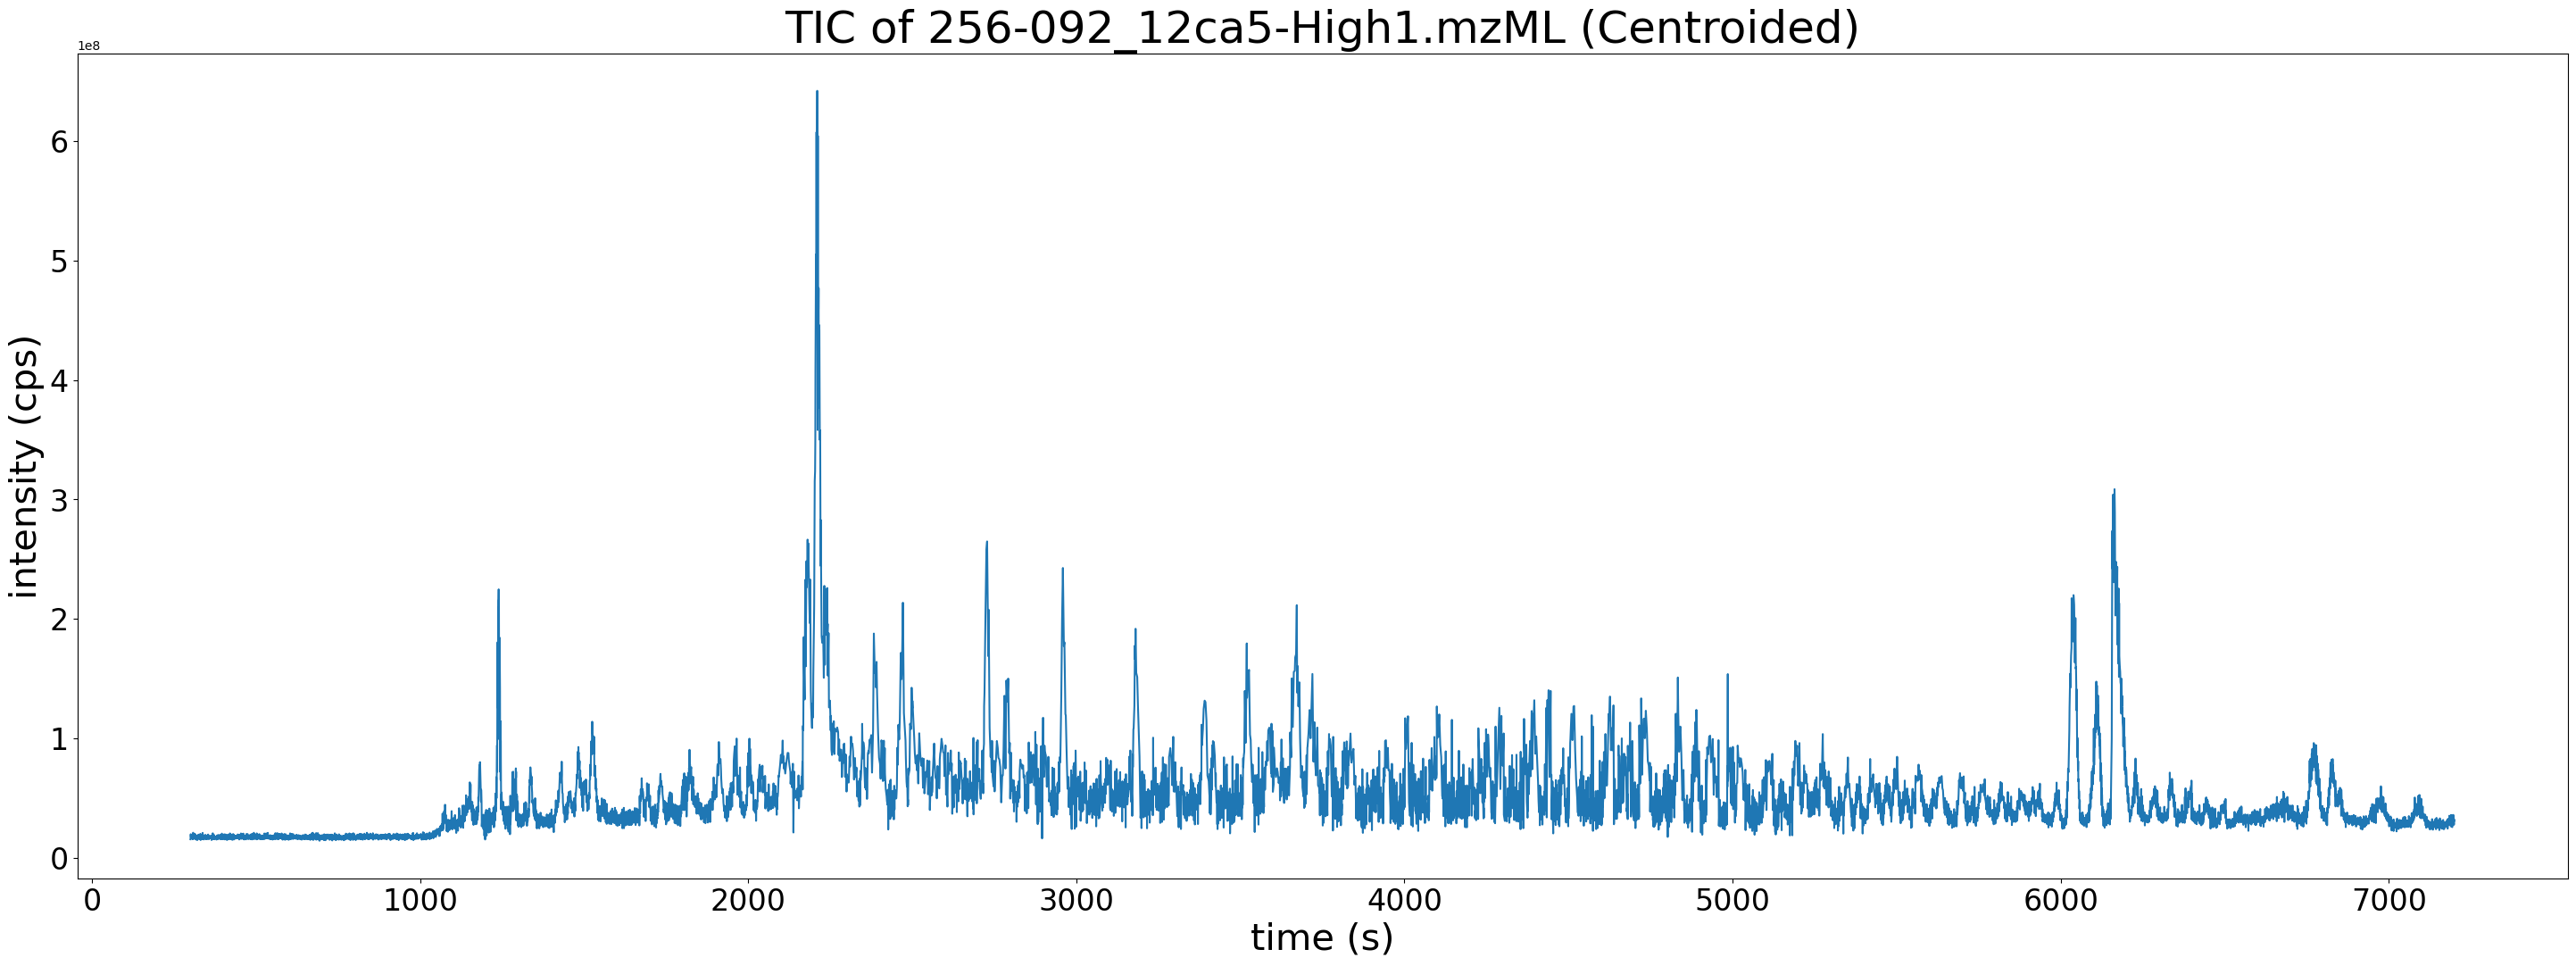

loaded
Fifth percentile = 17066231.0


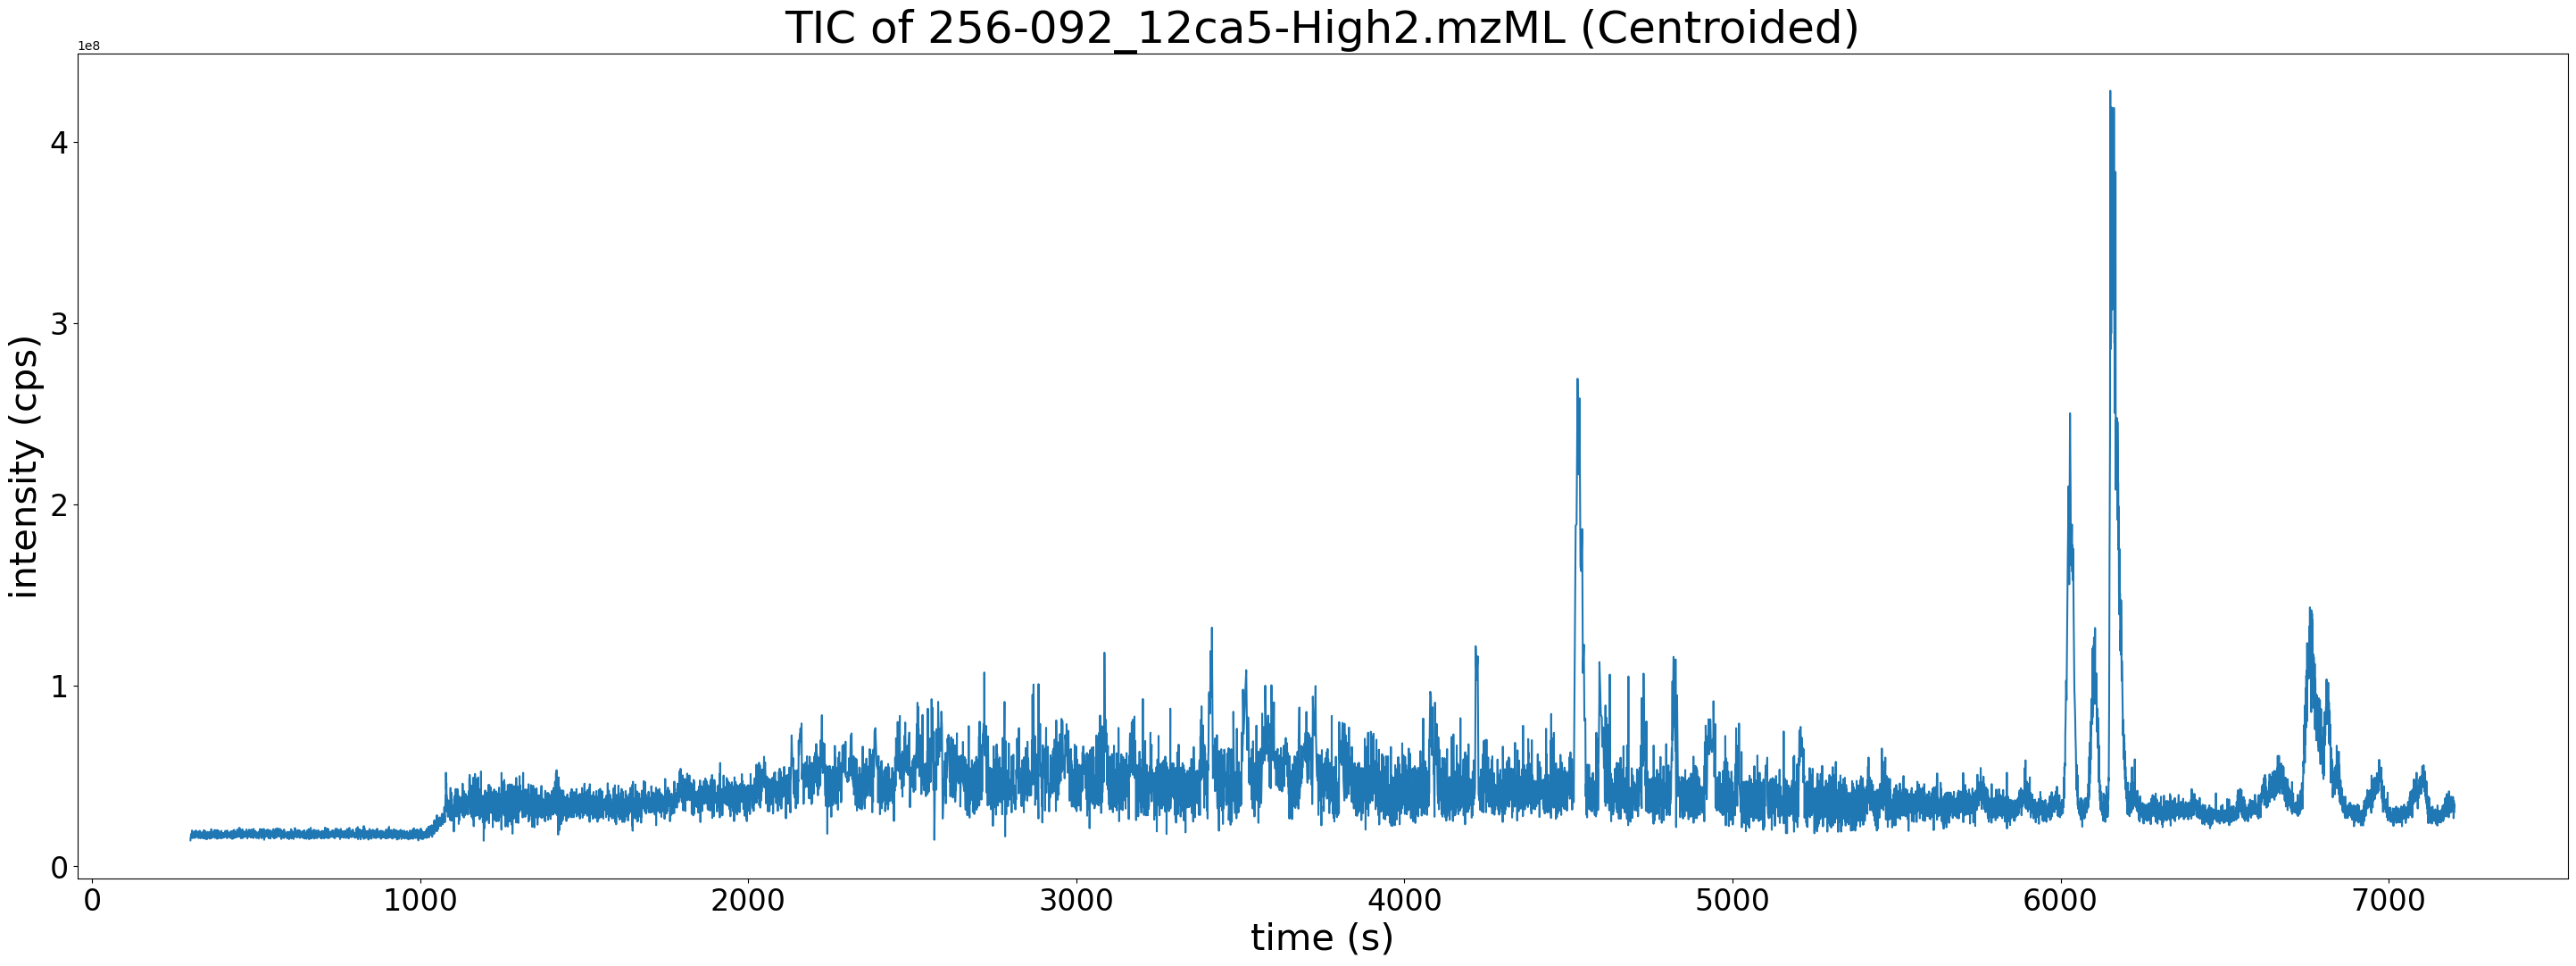

loaded
Fifth percentile = 16715892.0


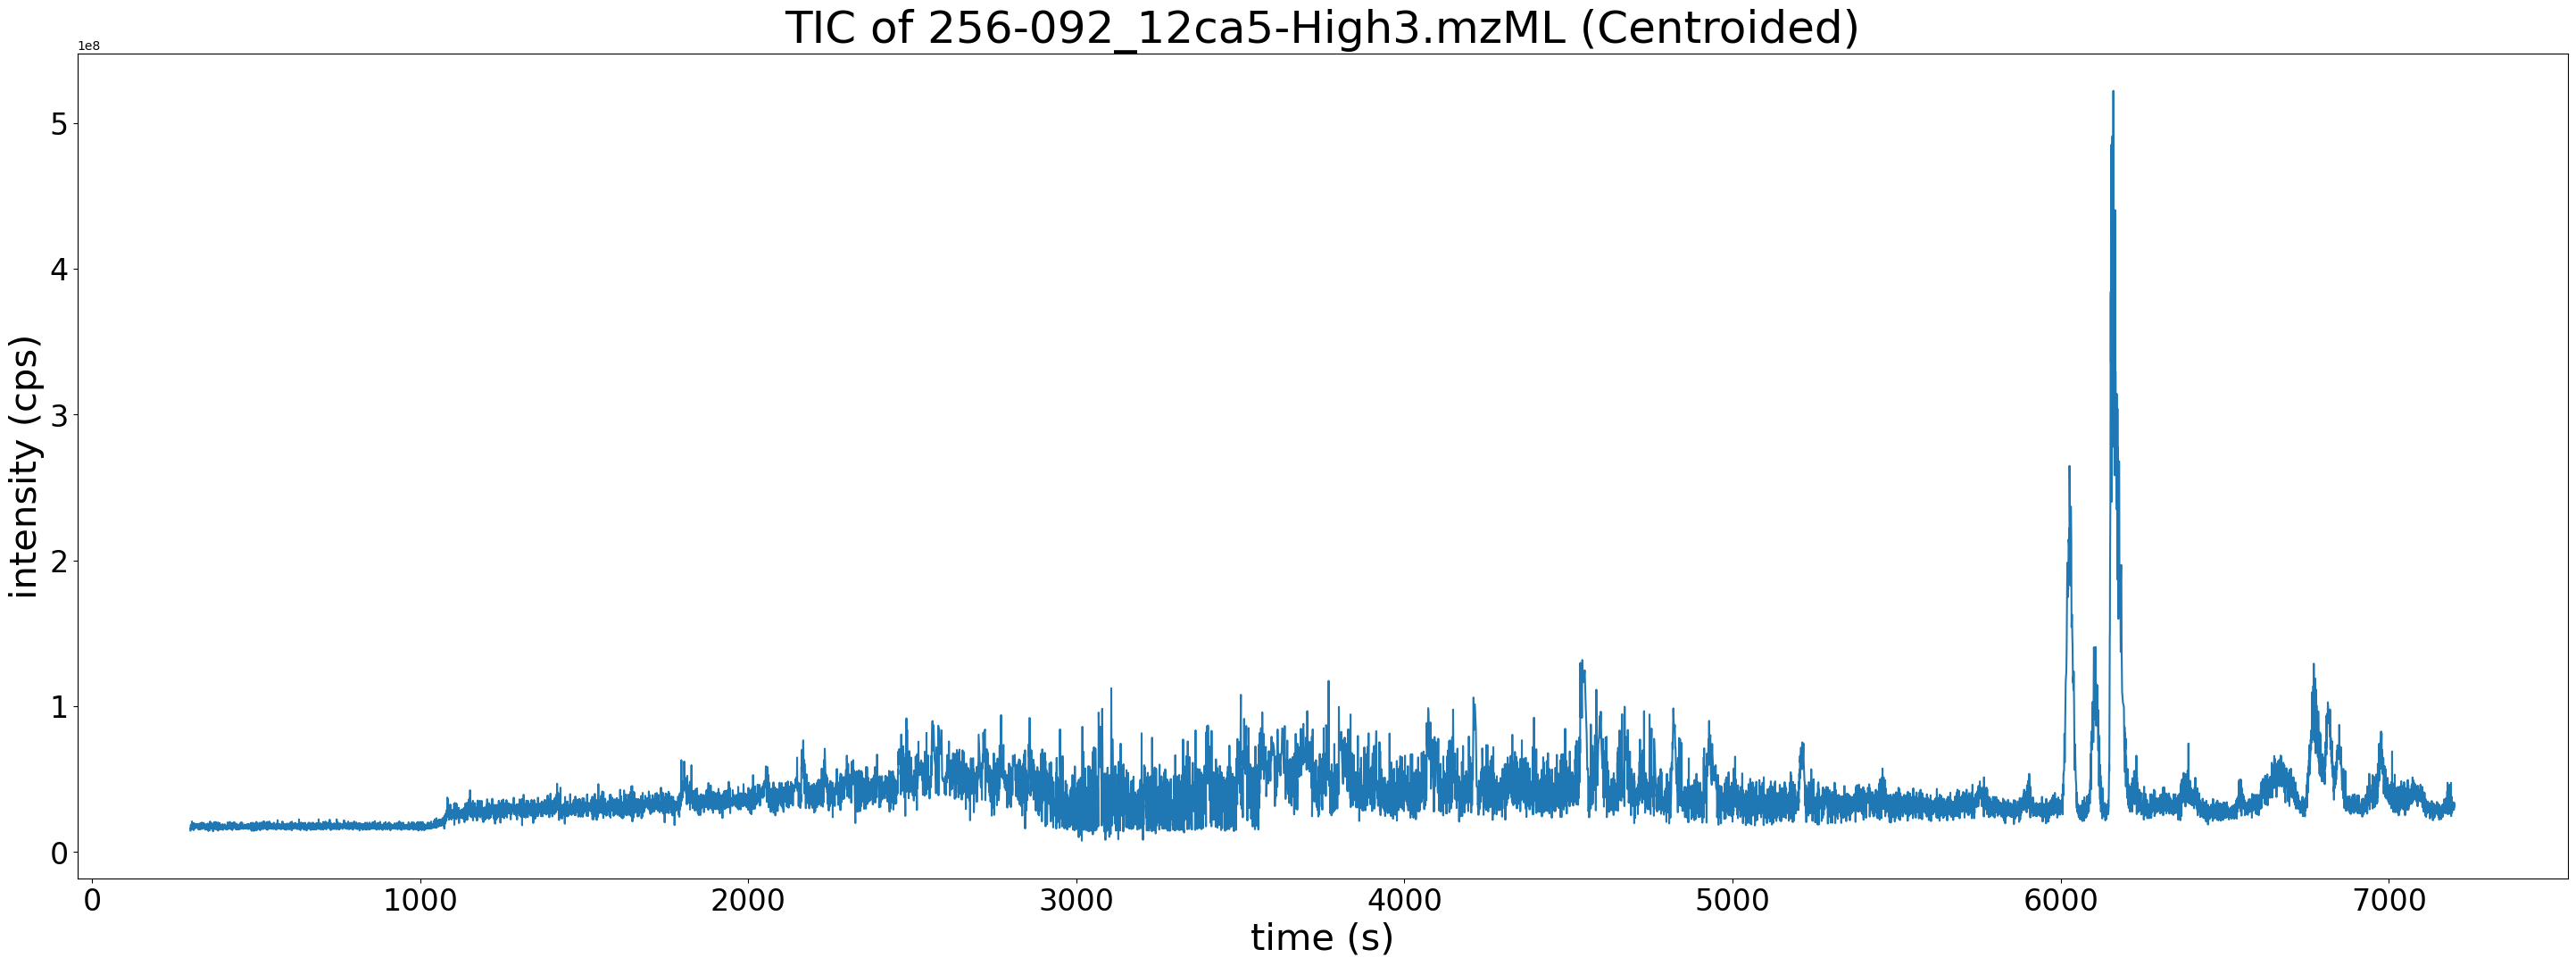

loaded
Fifth percentile = 16269881.15


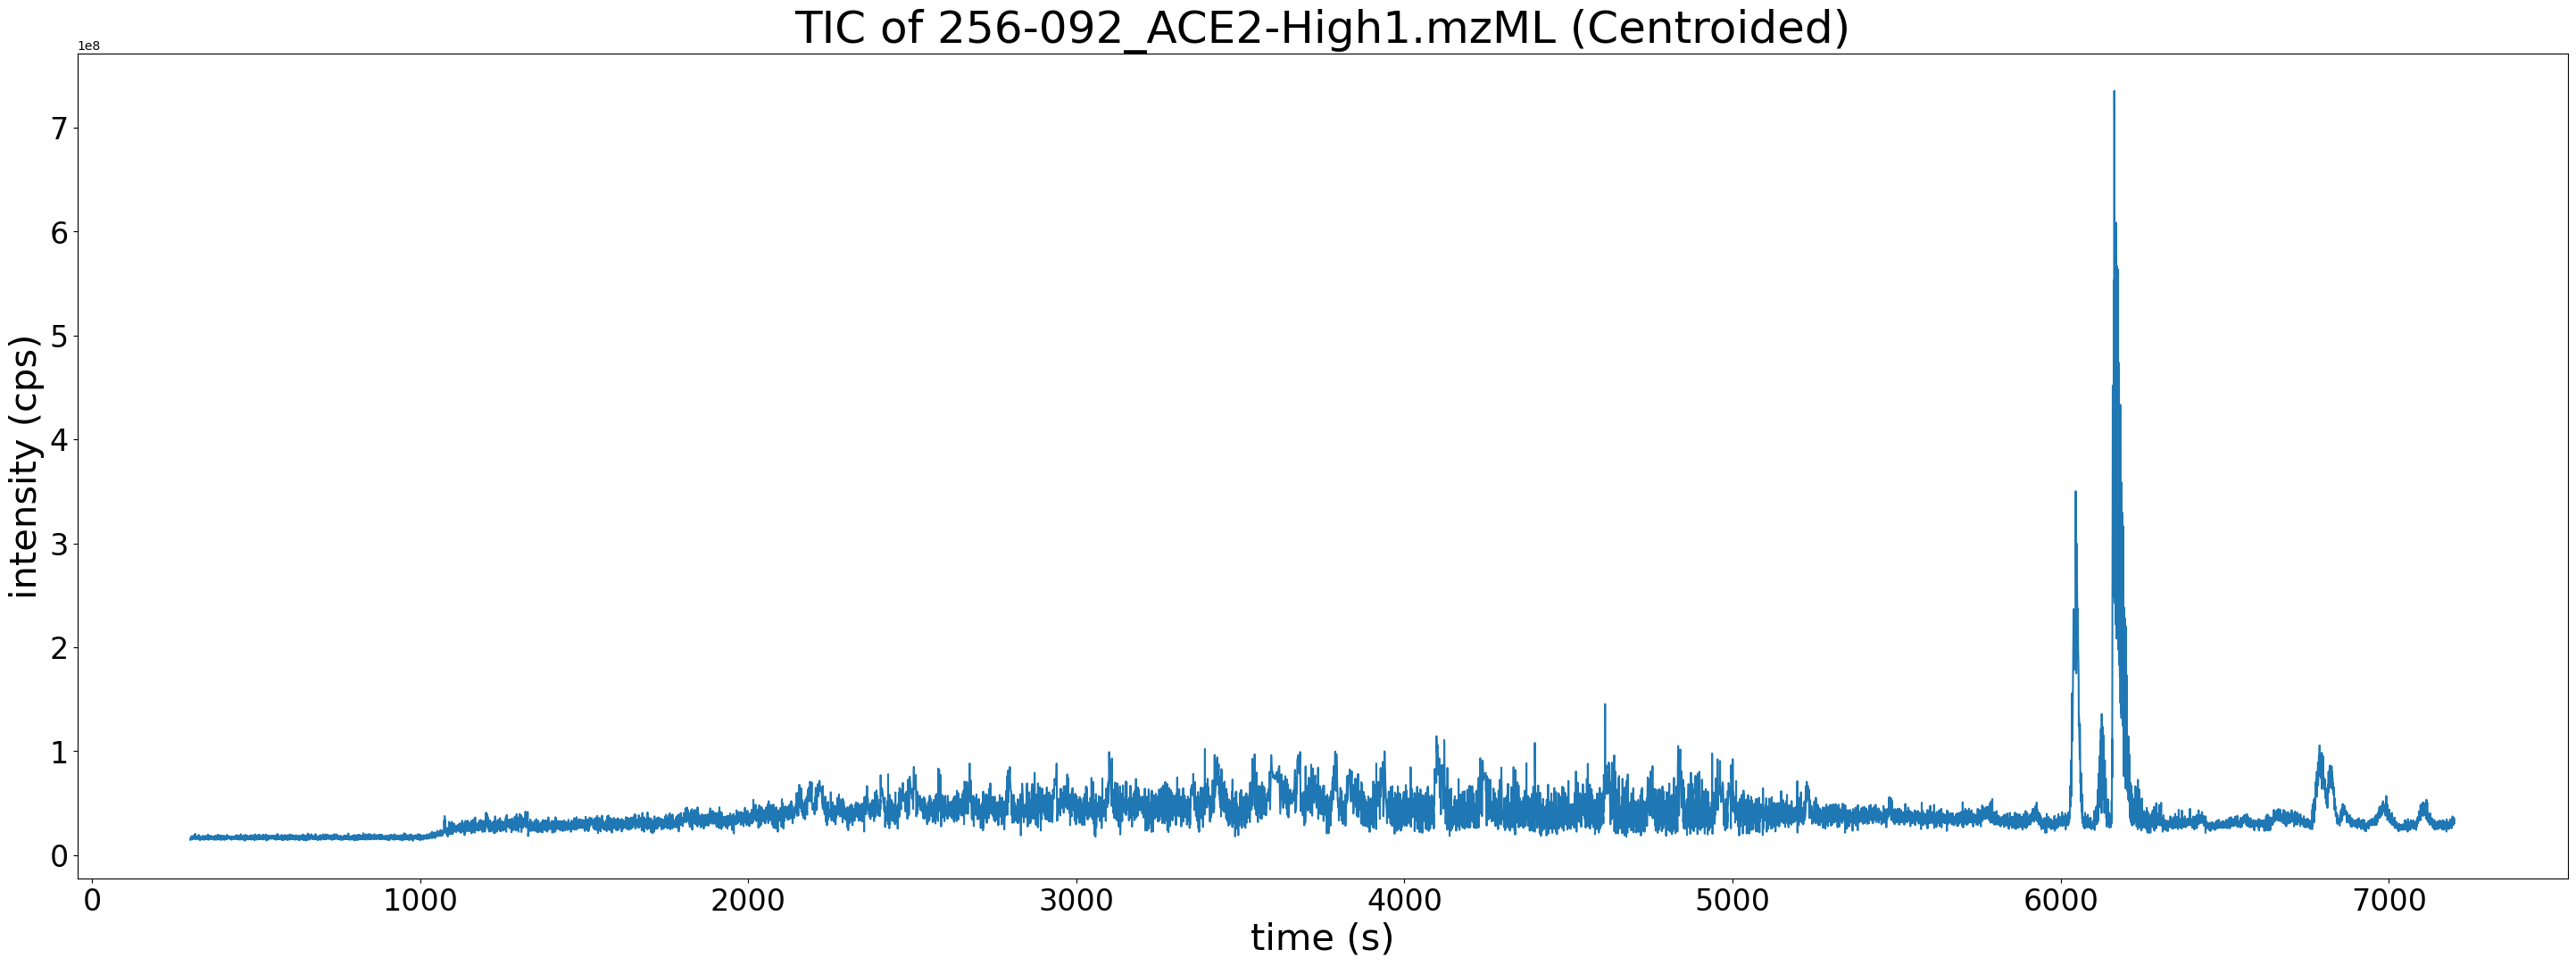

loaded
Fifth percentile = 19263850.2


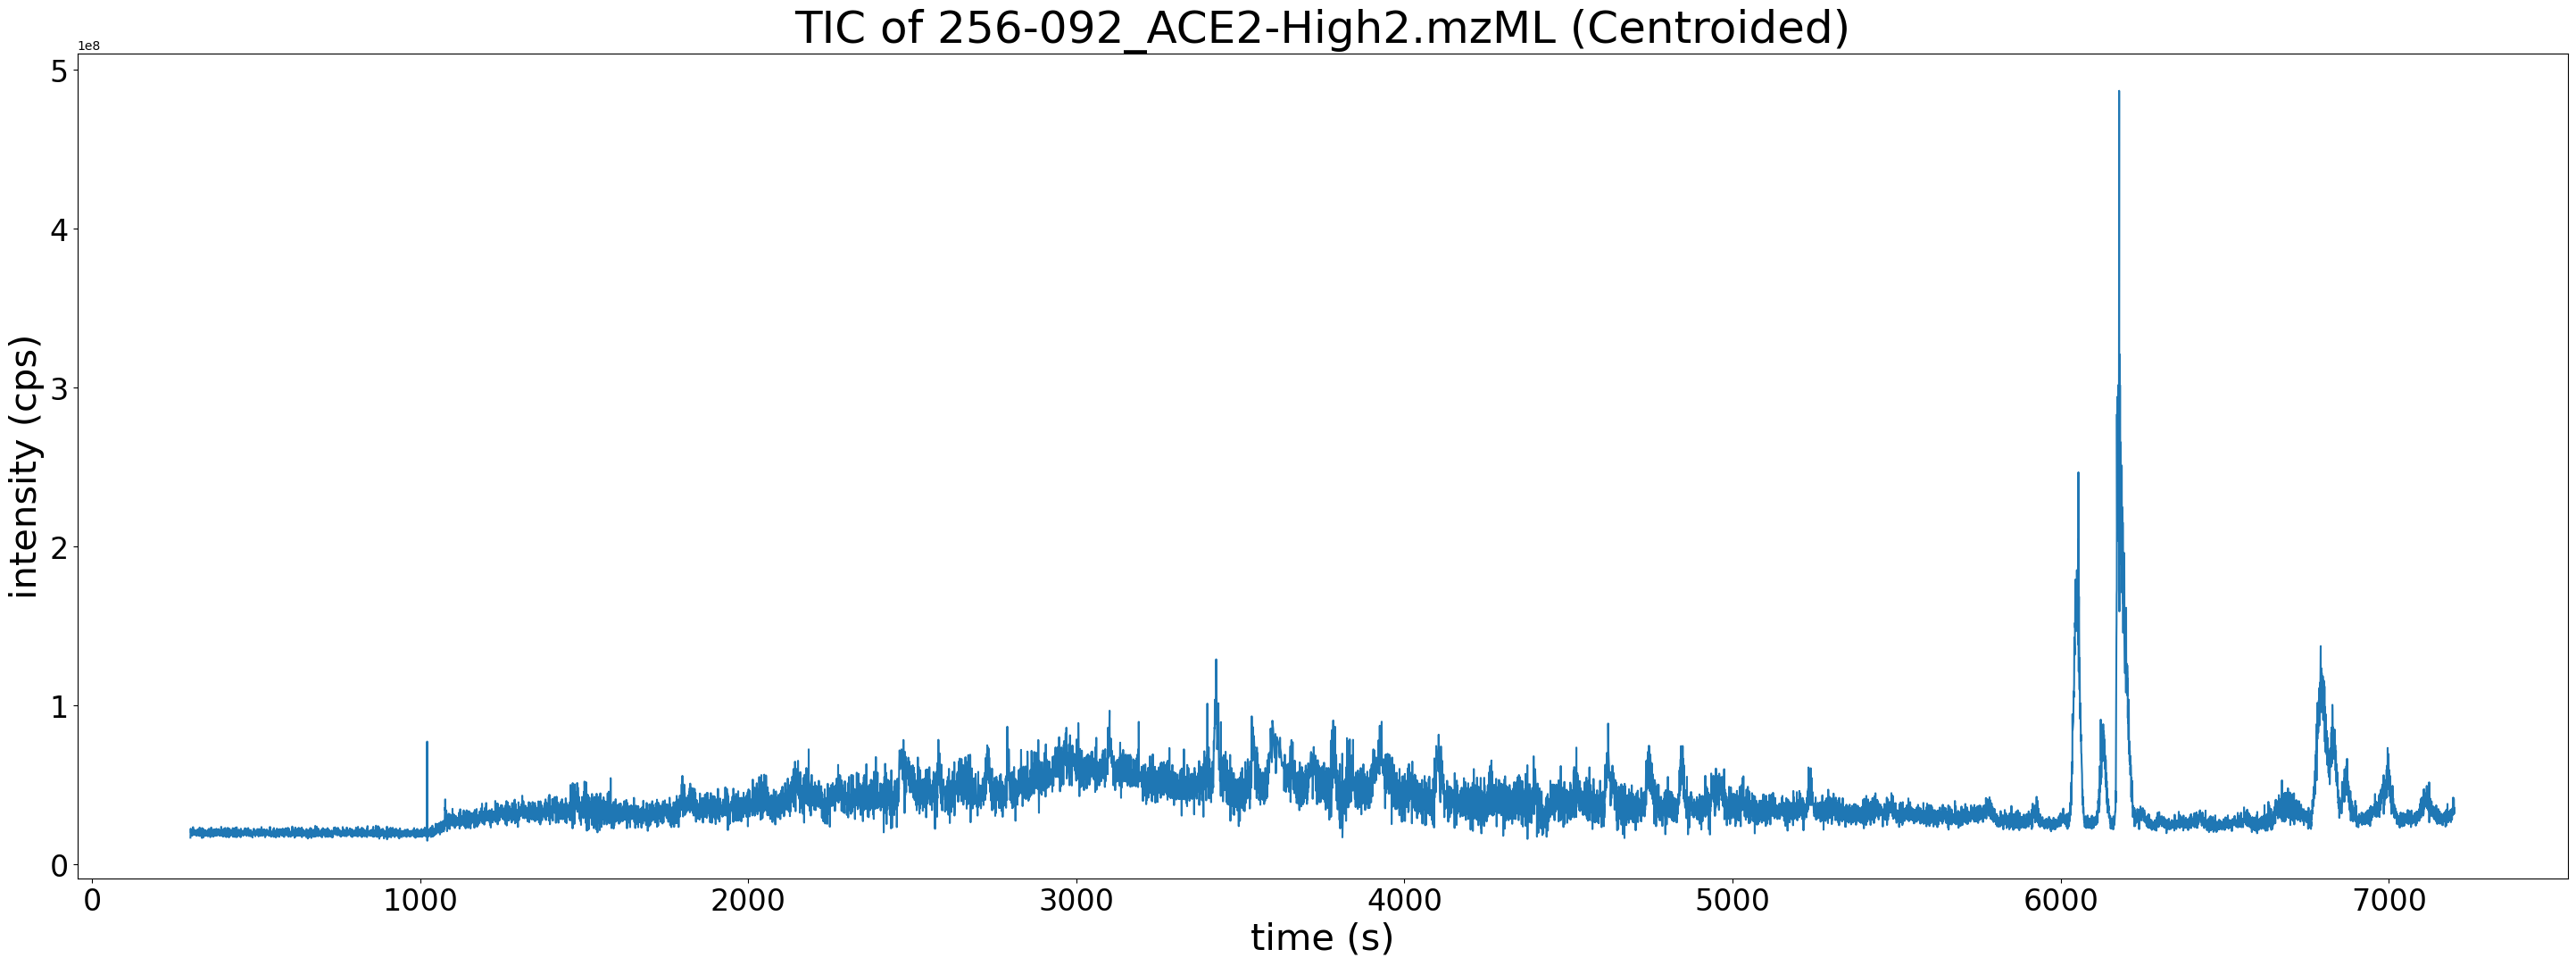

loaded
Fifth percentile = 17021497.2


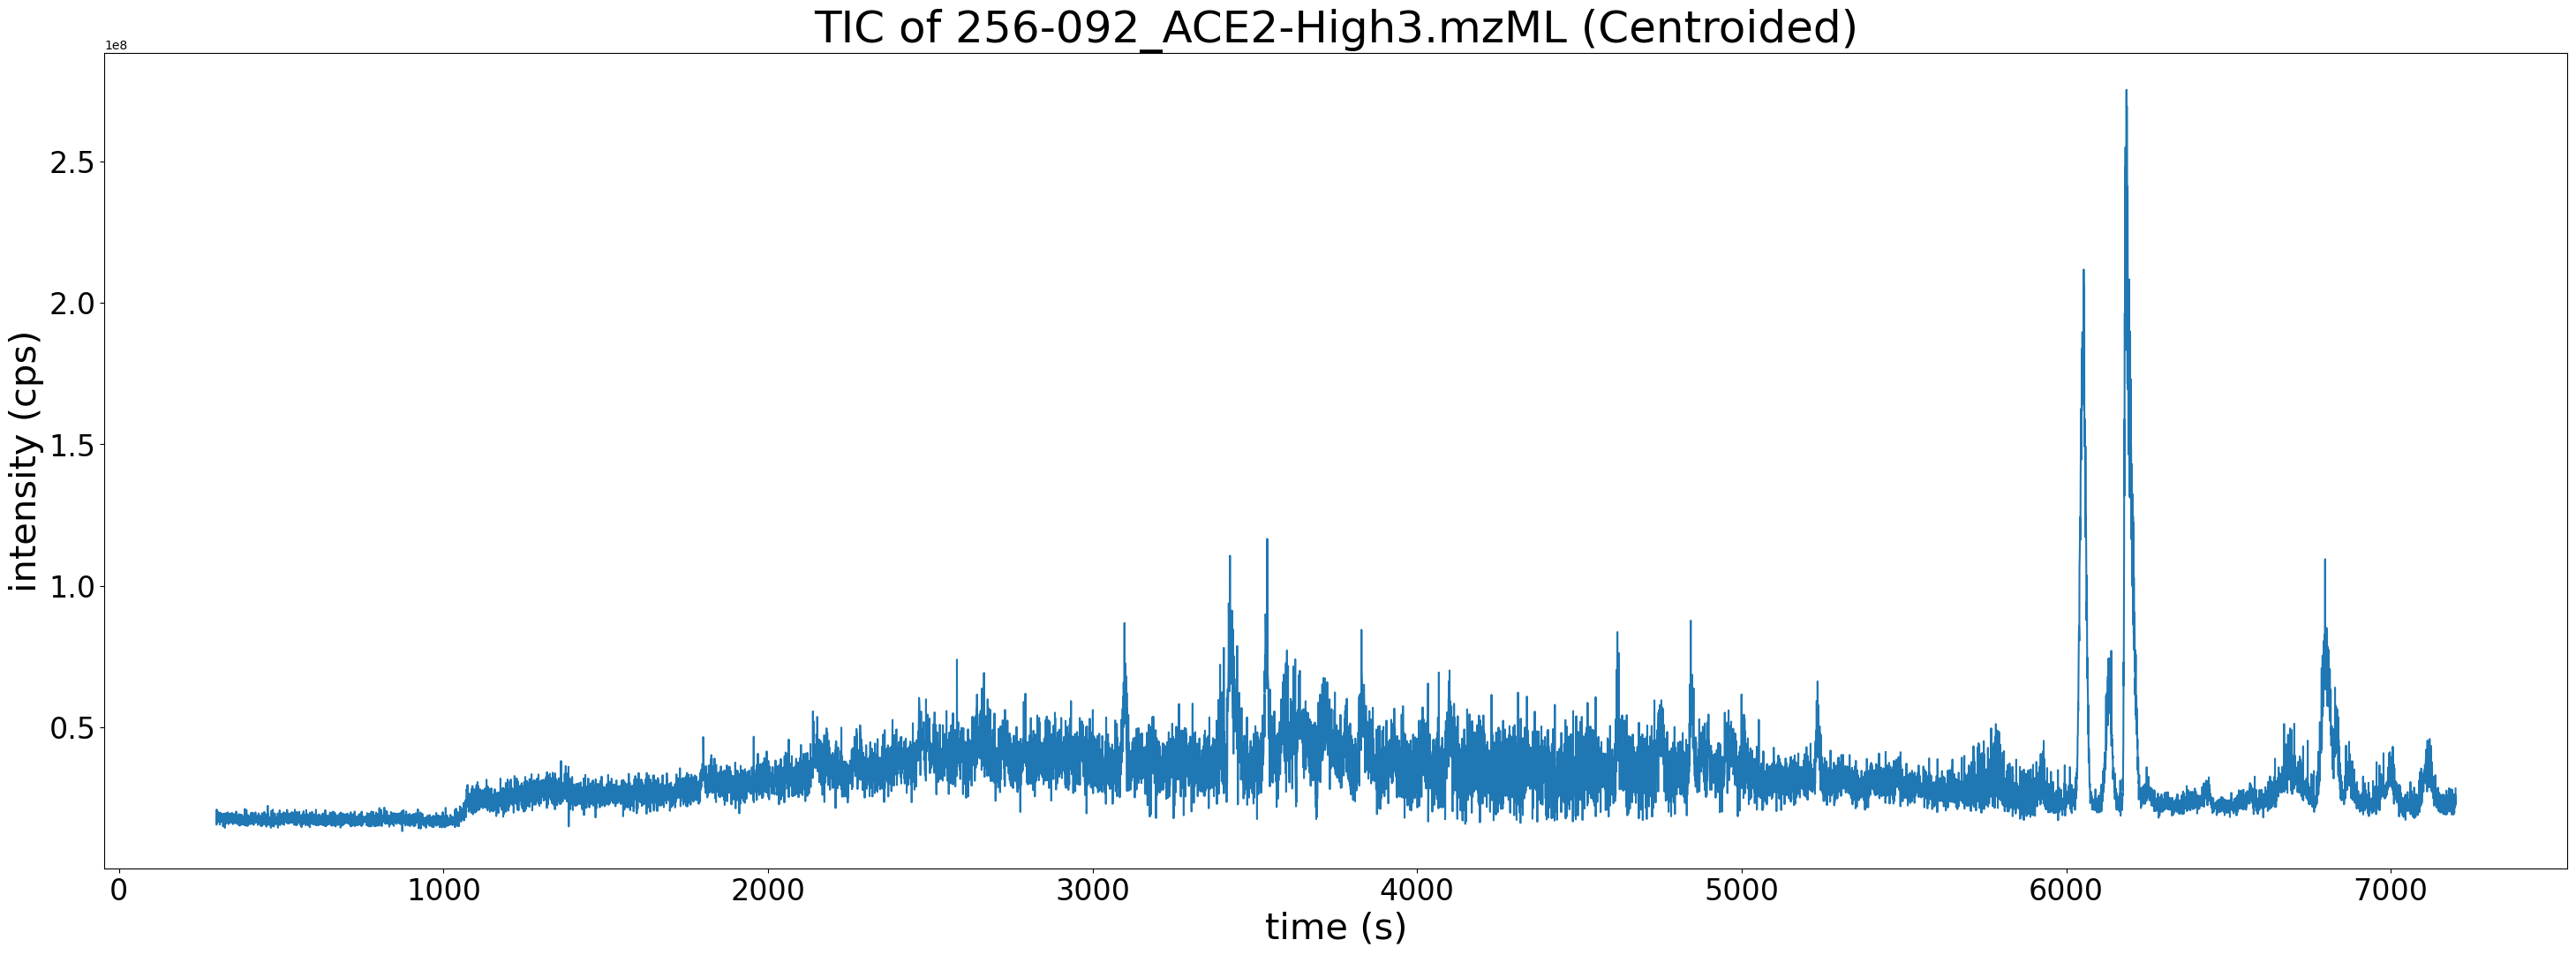

loaded
Fifth percentile = 16585655.5


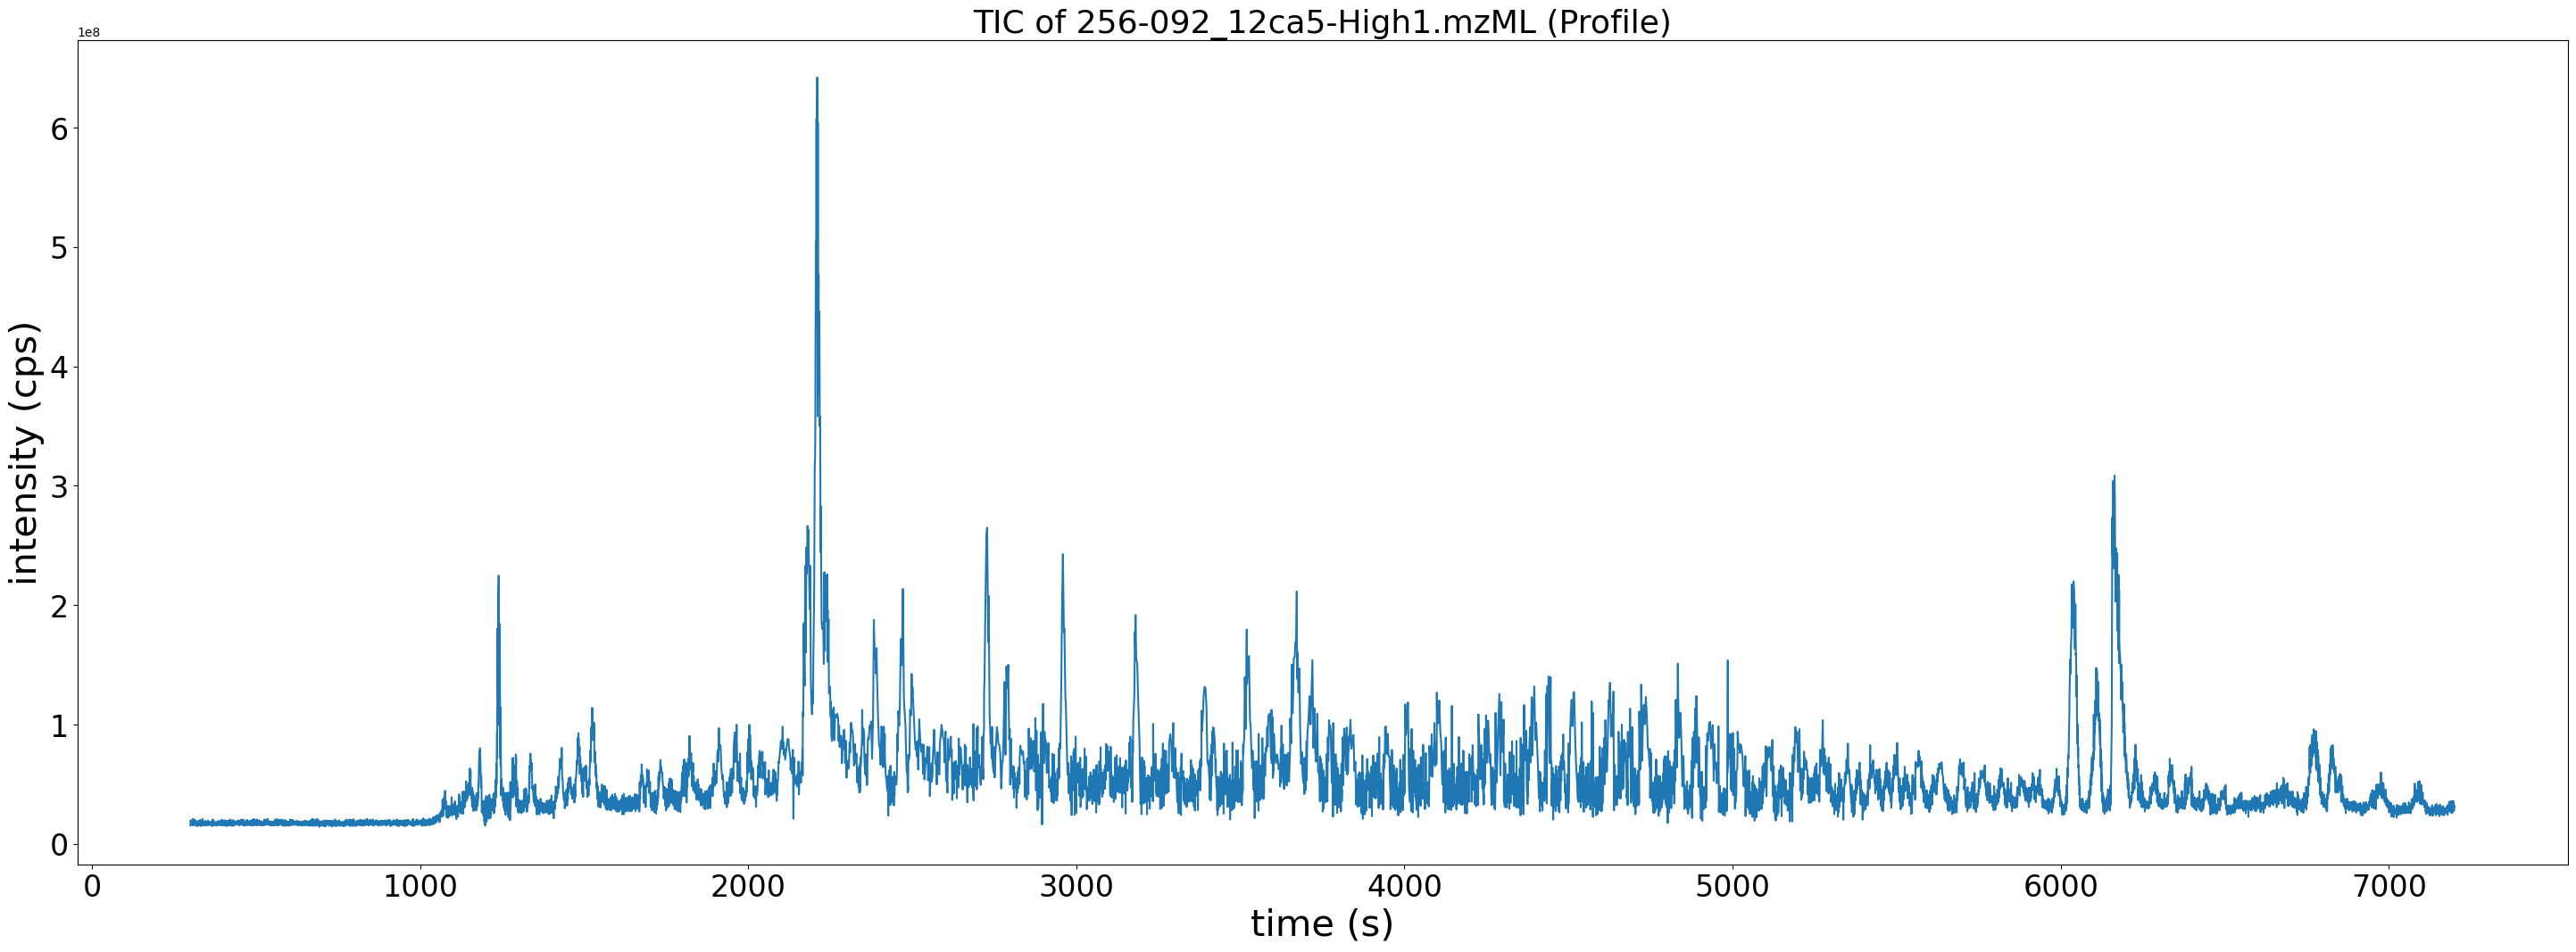

loaded
Fifth percentile = 17066231.0


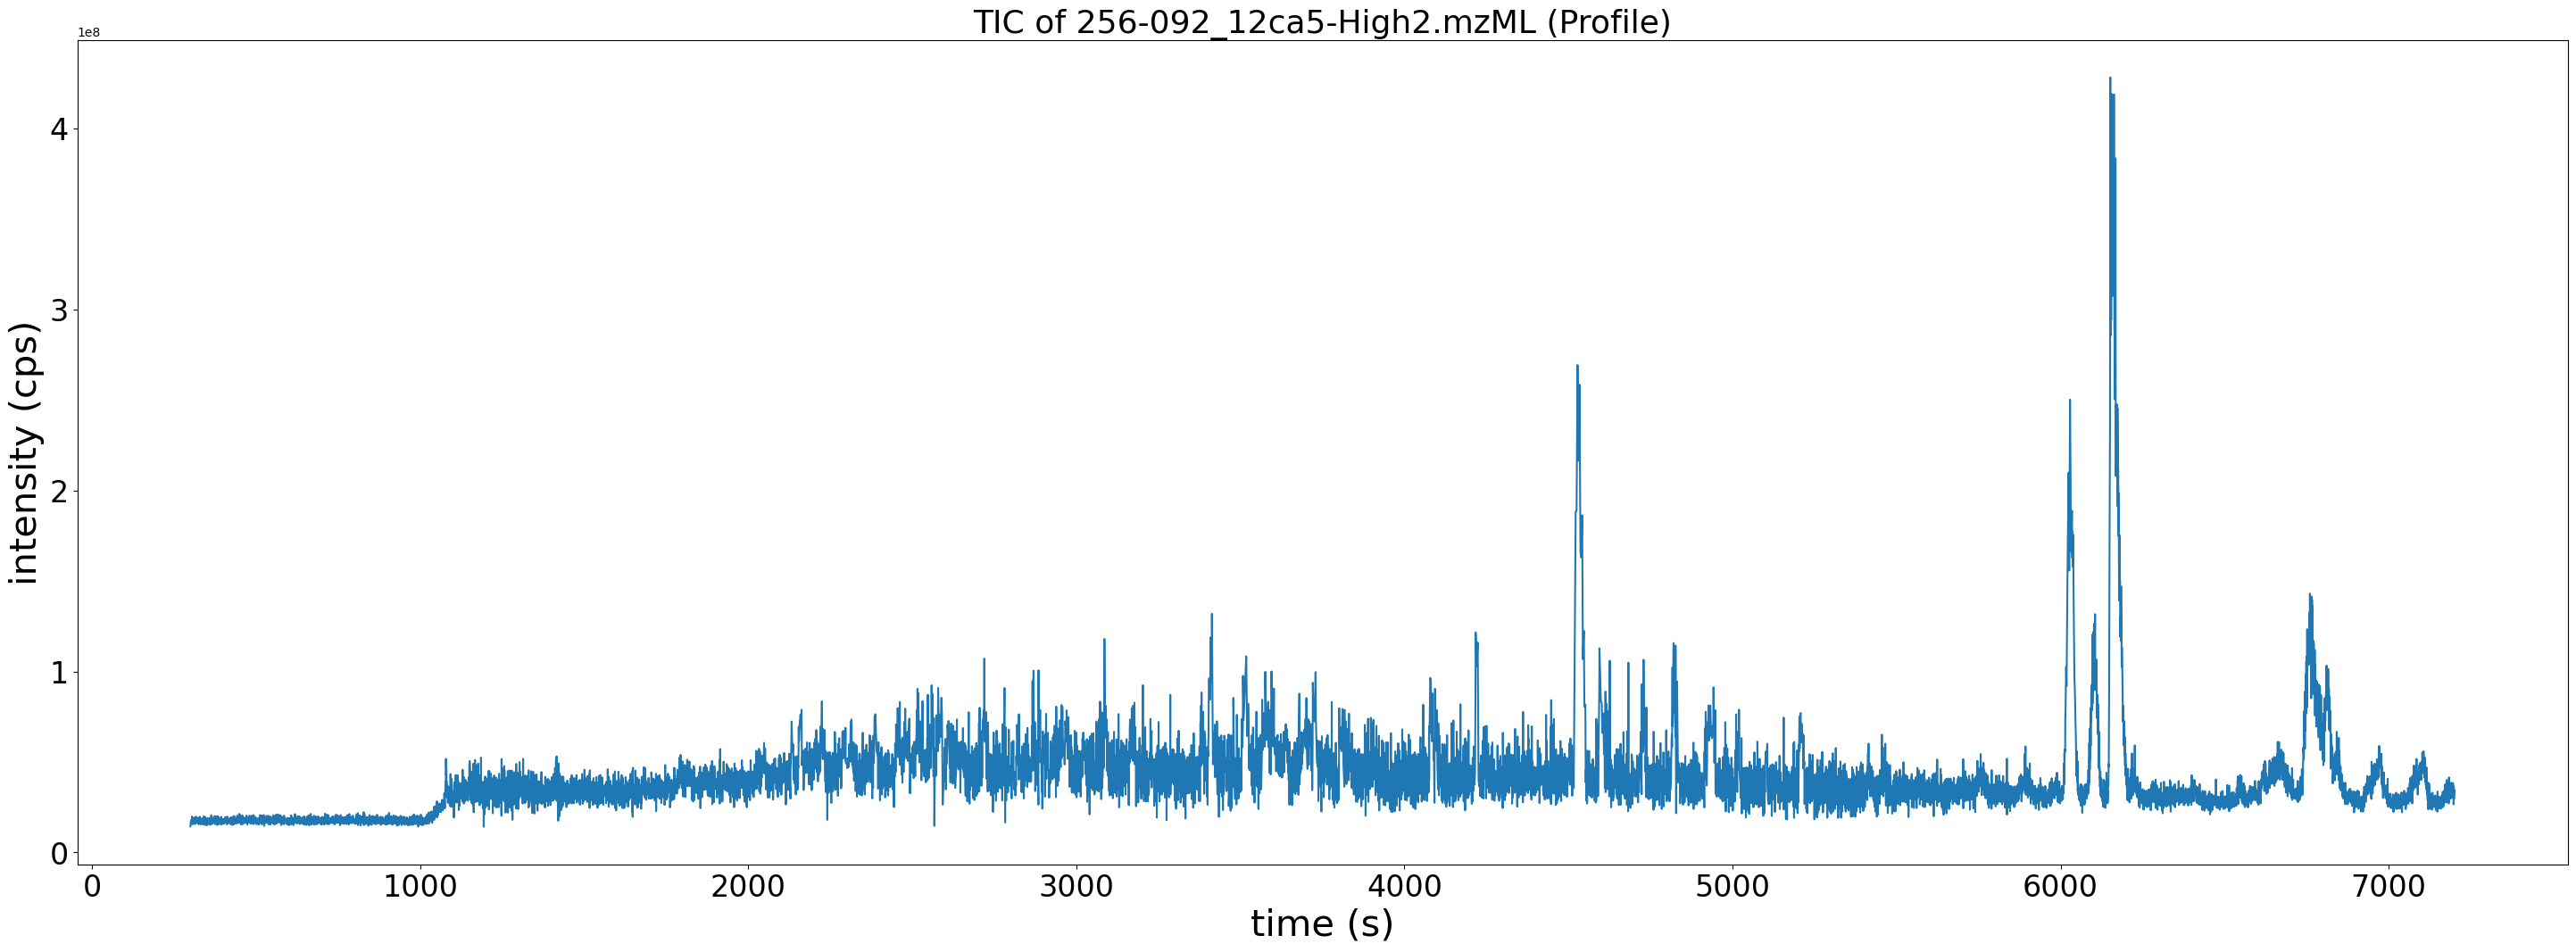

loaded
Fifth percentile = 16715892.0


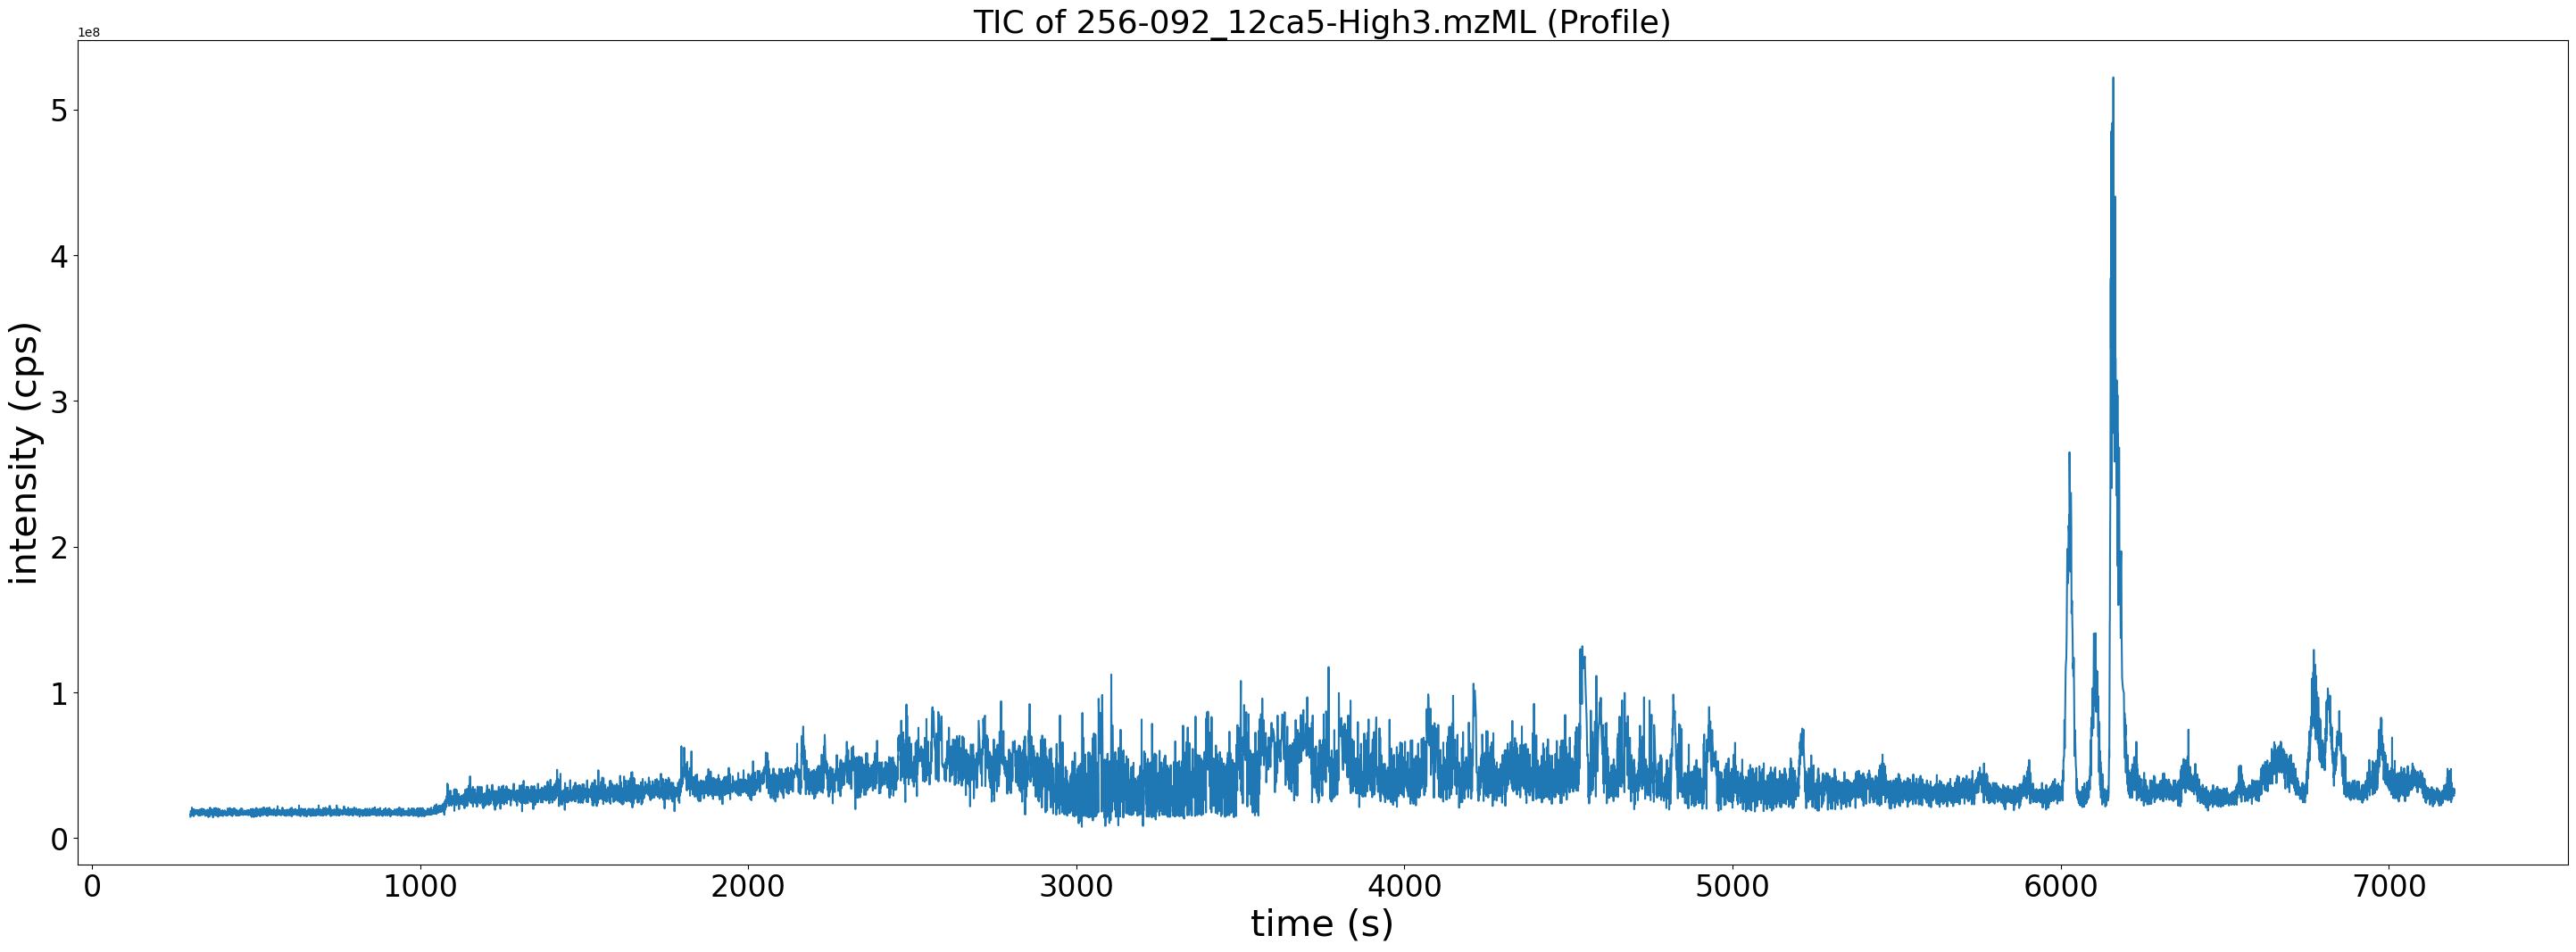

loaded
Fifth percentile = 16269881.15


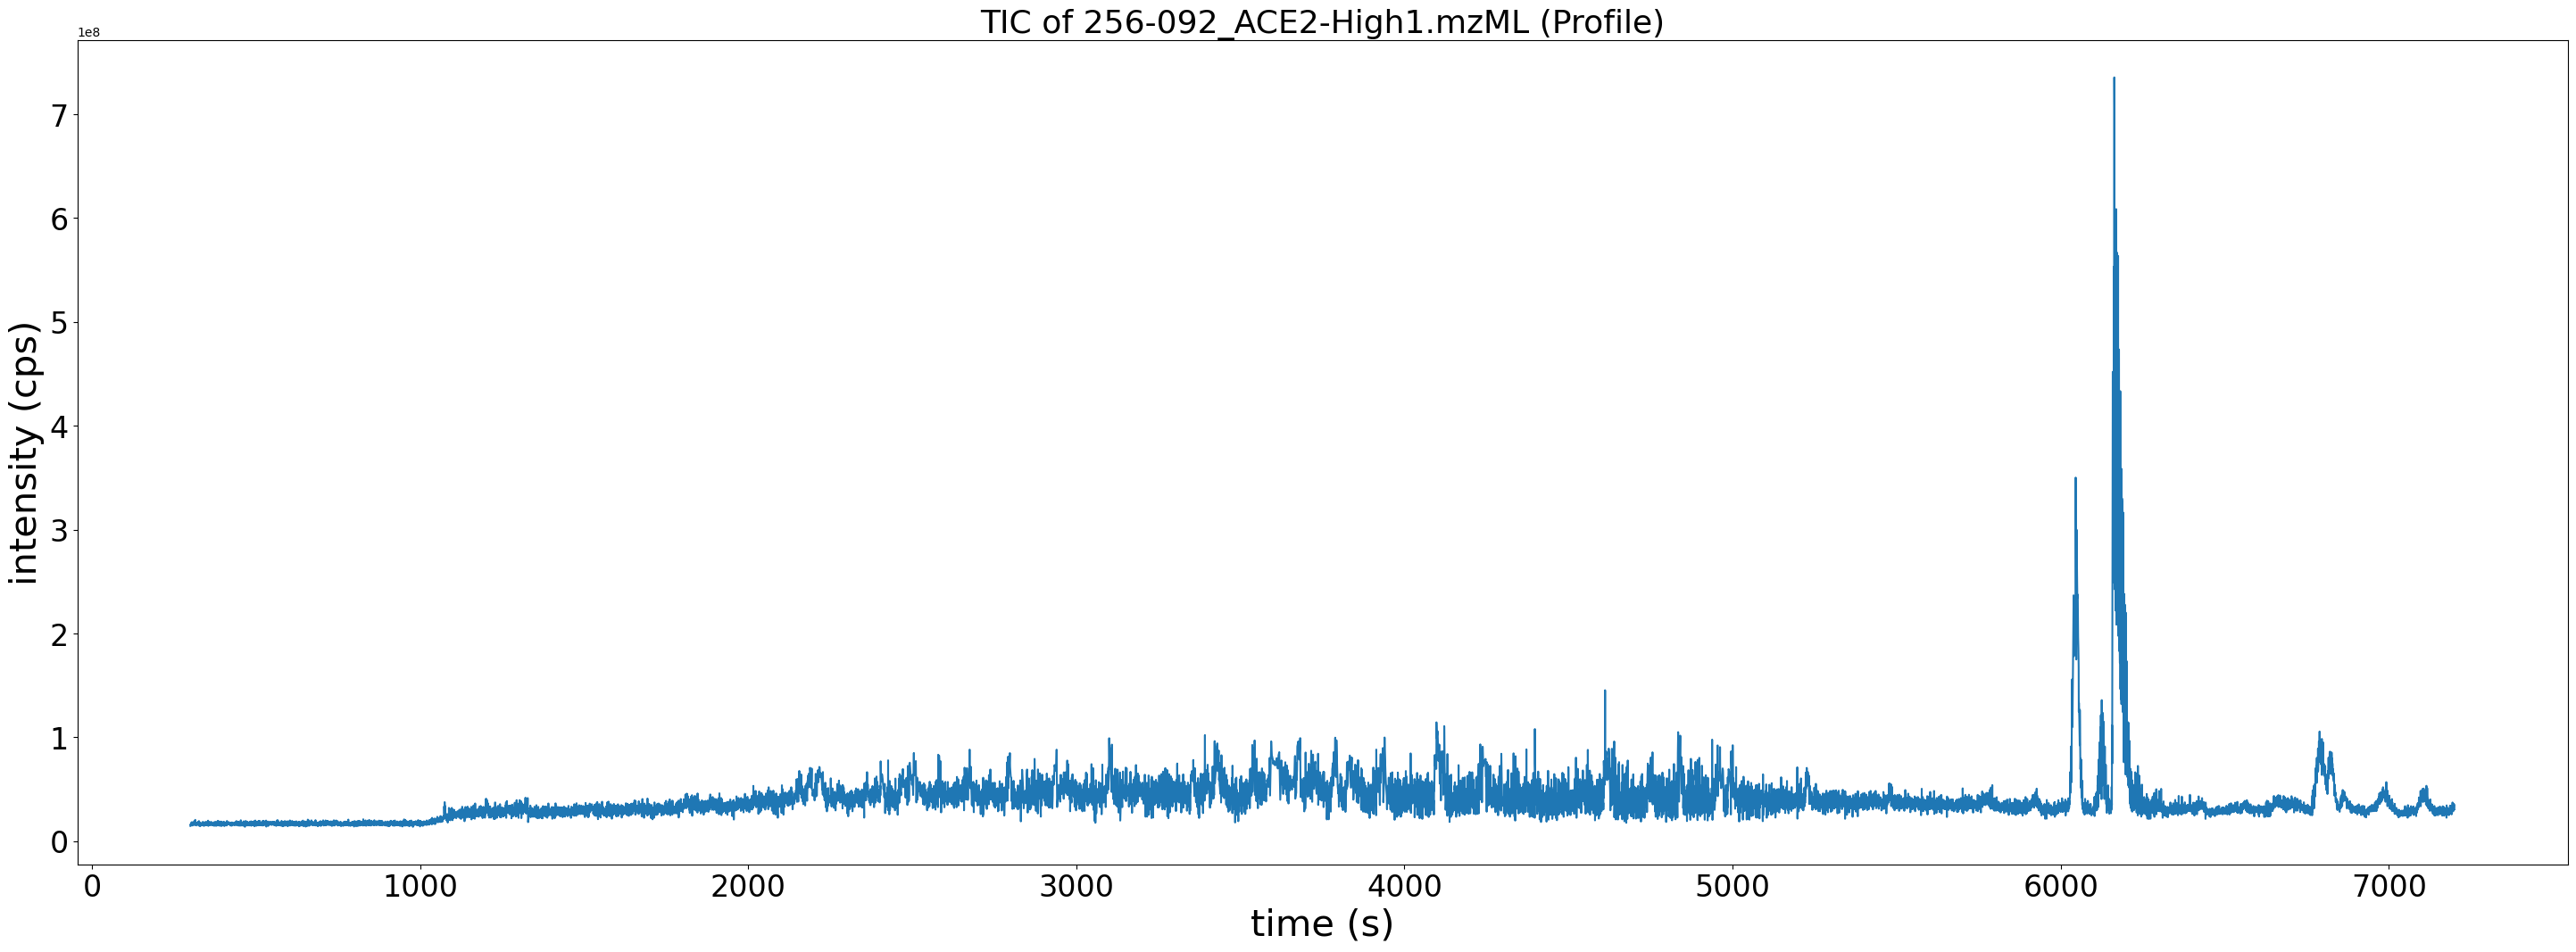

loaded
Fifth percentile = 19263850.2


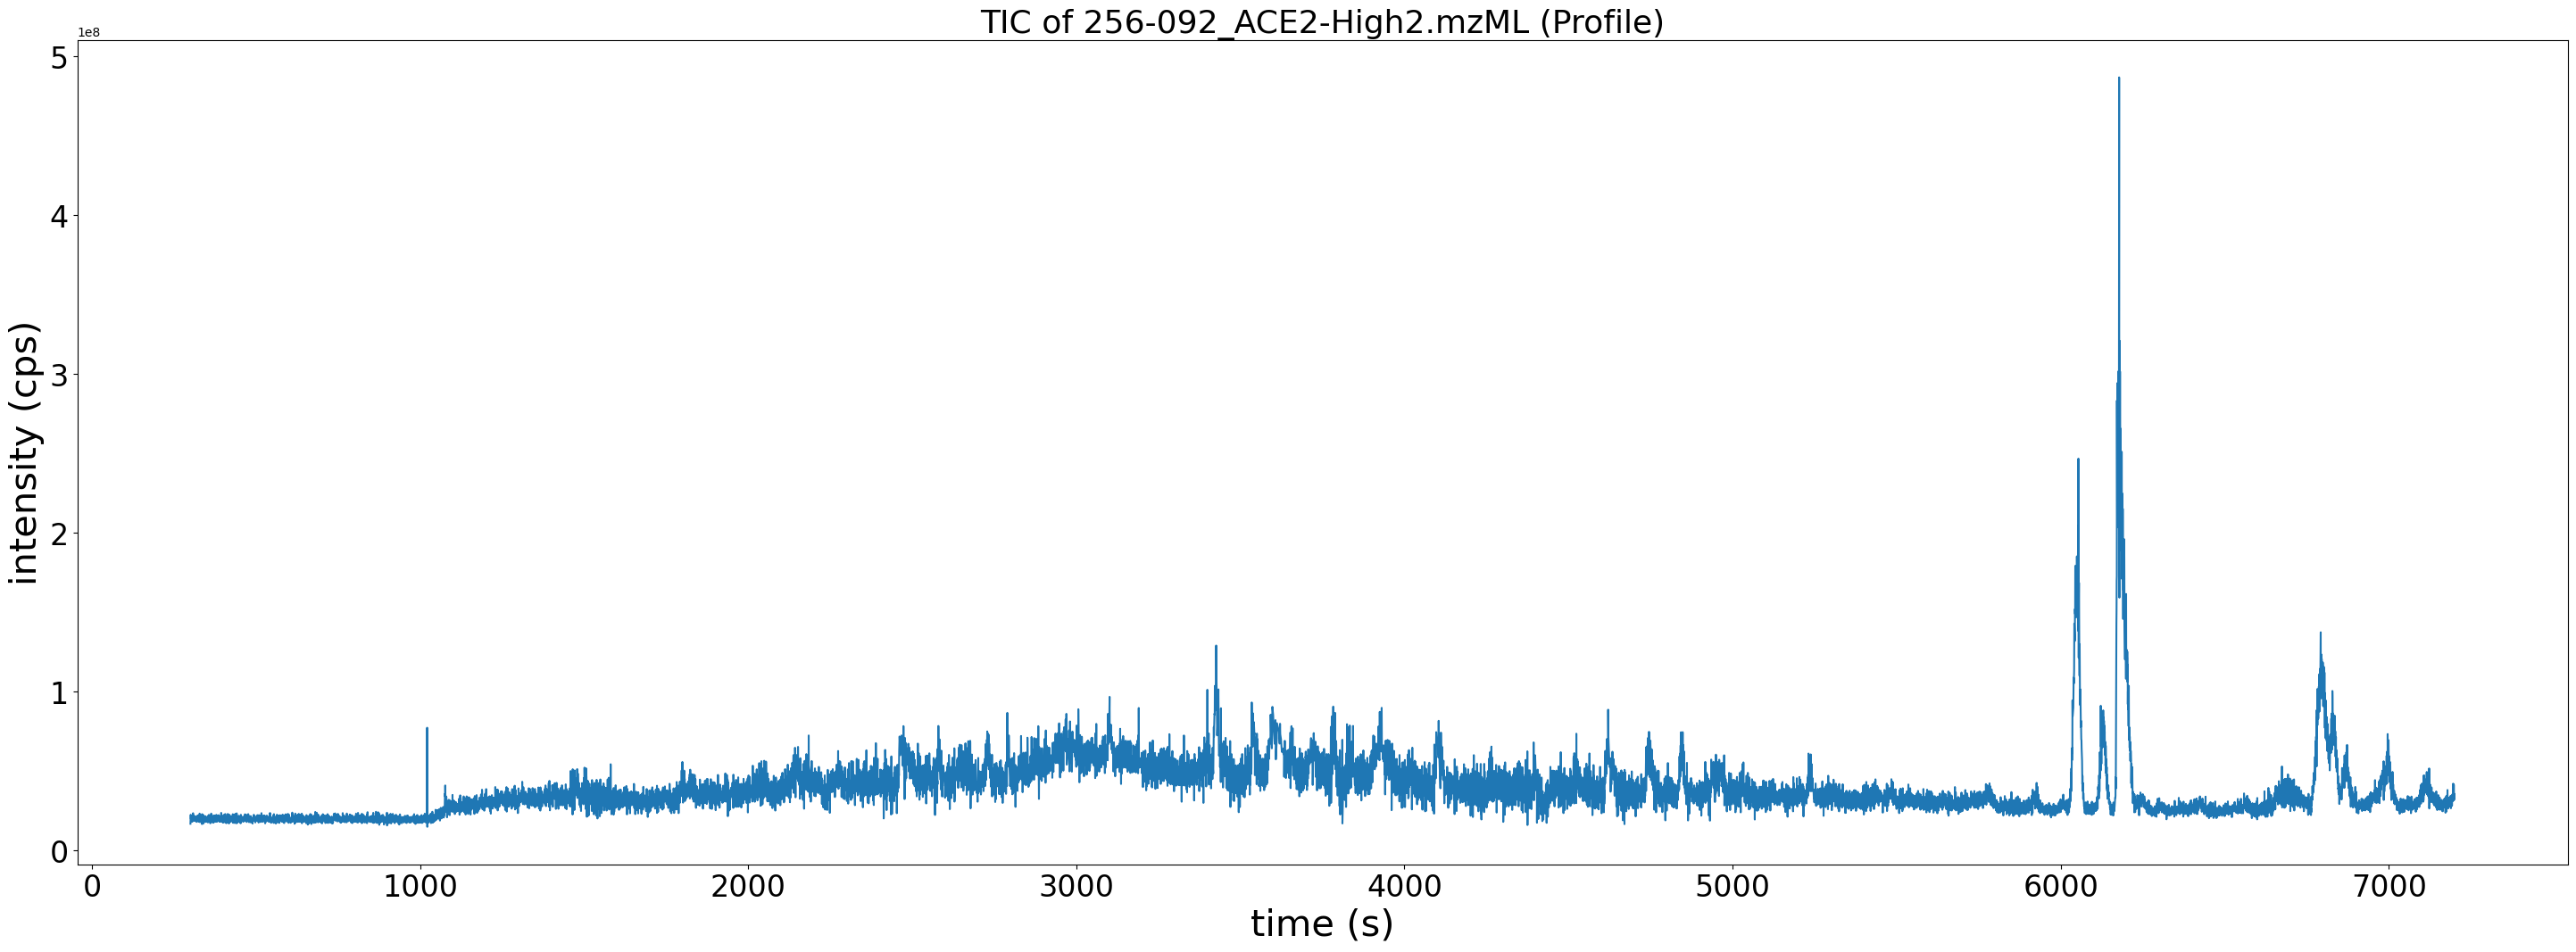

loaded
Fifth percentile = 17021497.2


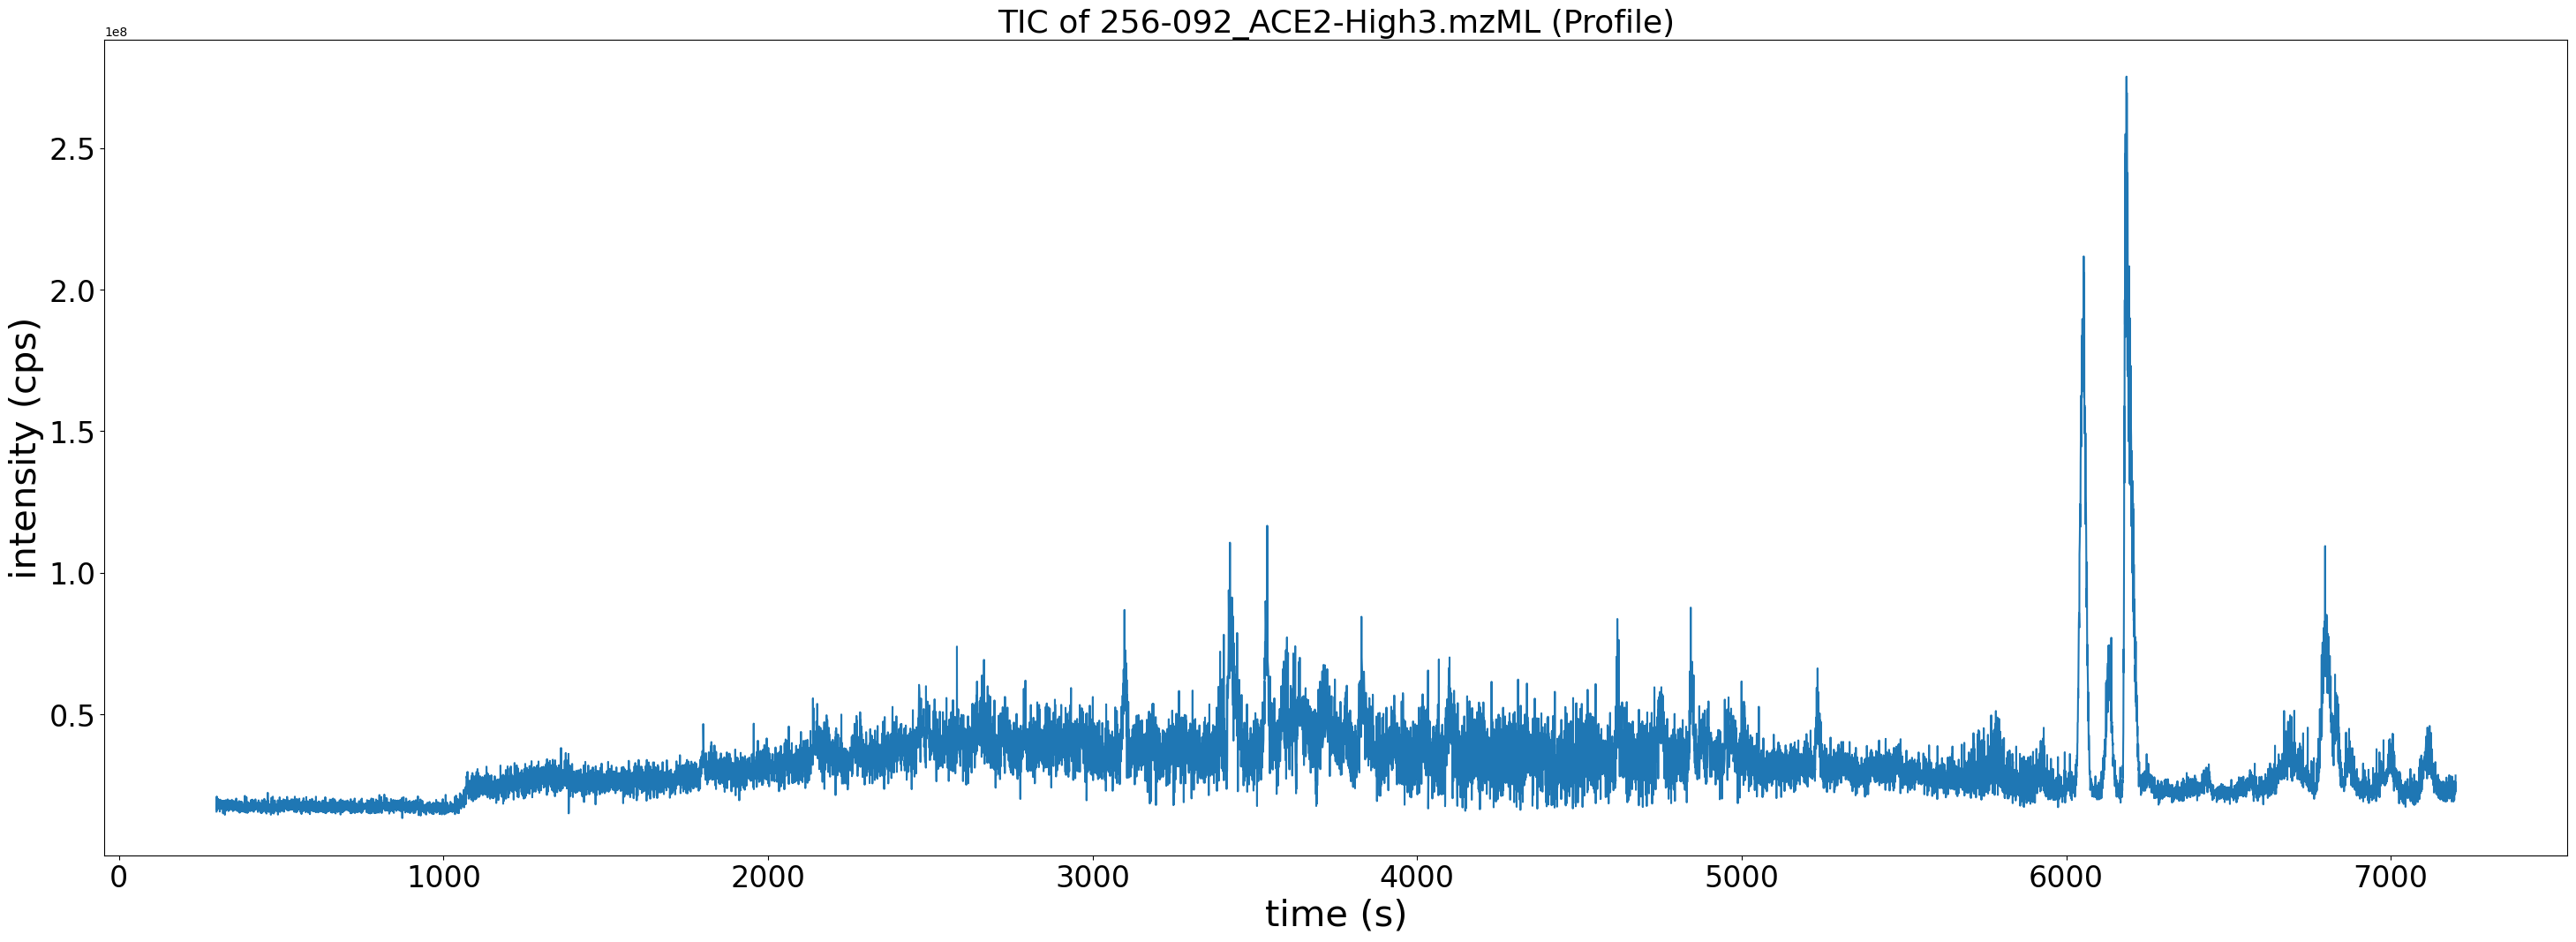

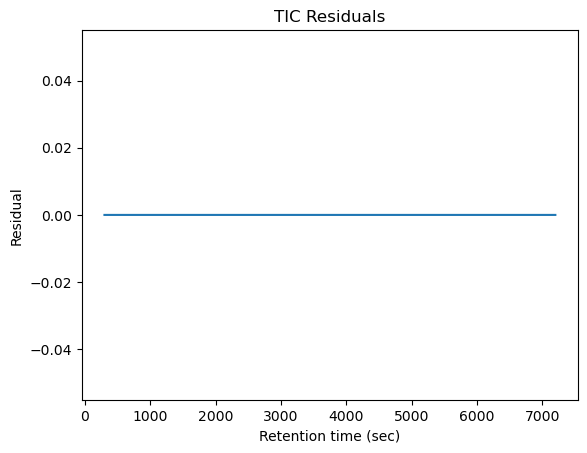

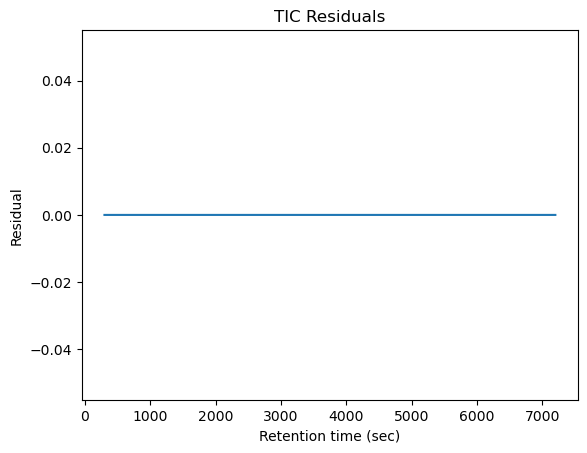

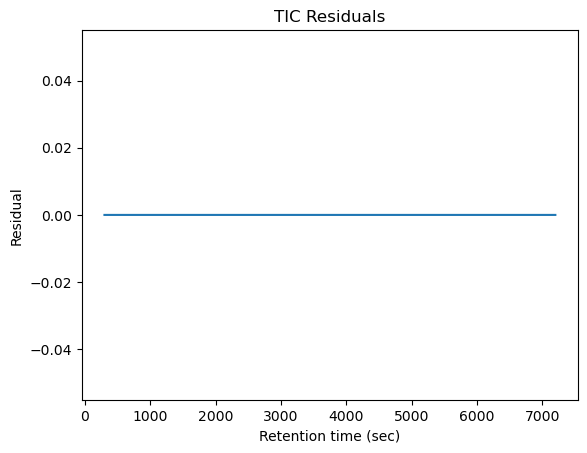

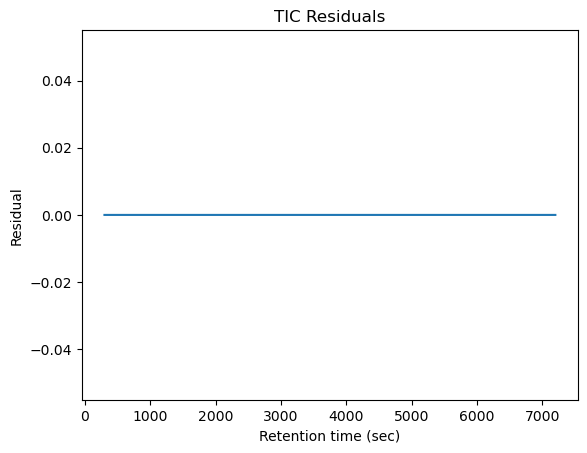

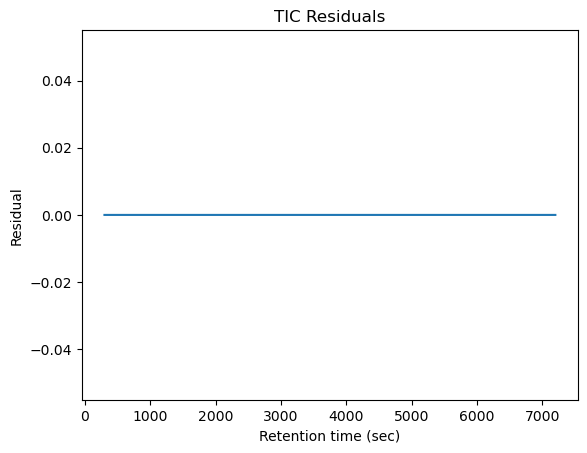

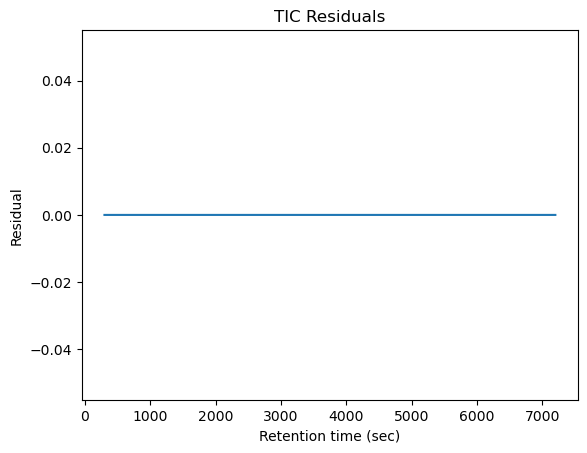

collecting peak data...


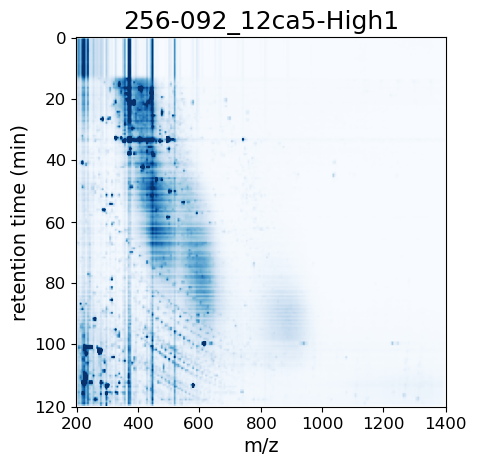

showing plot...
collecting peak data...


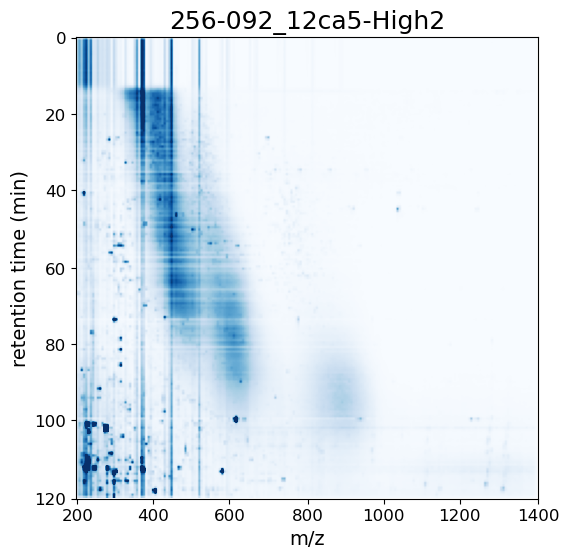

showing plot...
collecting peak data...


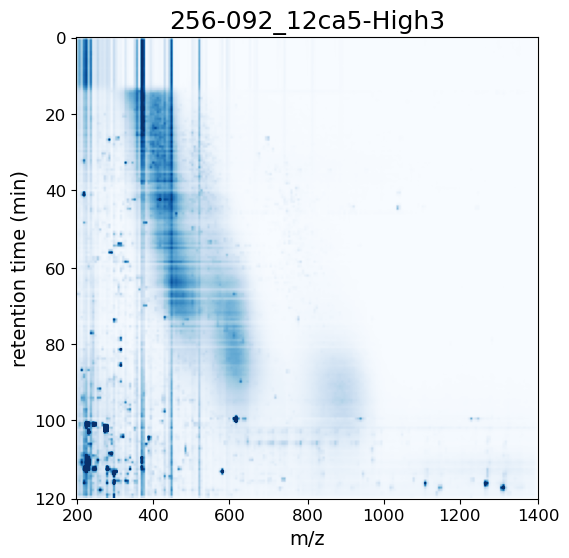

showing plot...
collecting peak data...


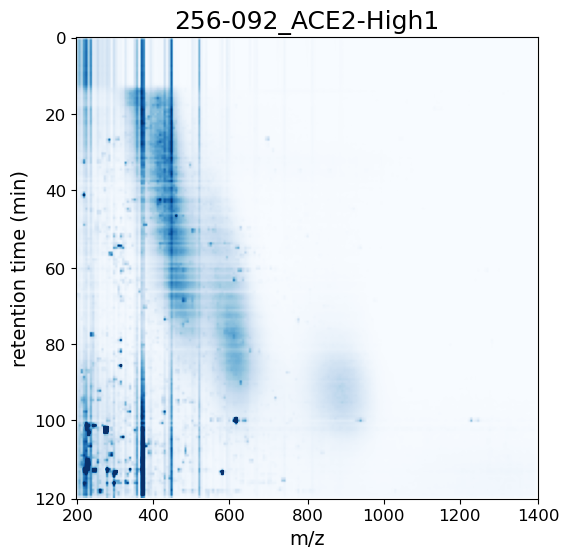

showing plot...
collecting peak data...


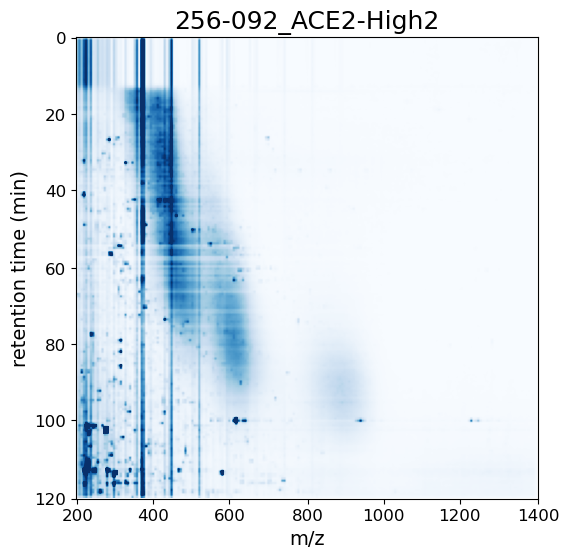

showing plot...
collecting peak data...


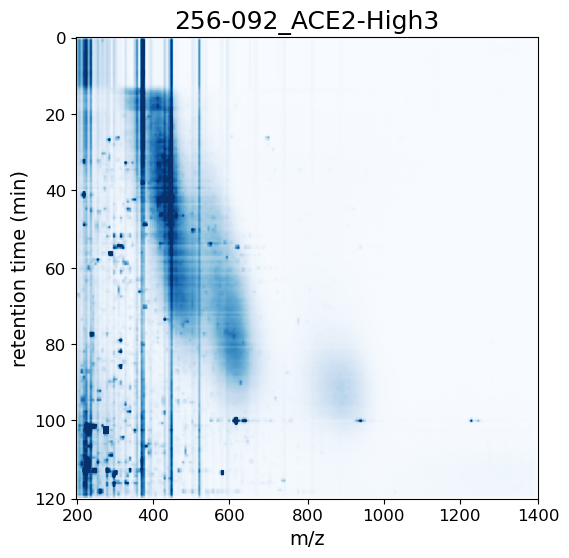

showing plot...
collecting peak data...


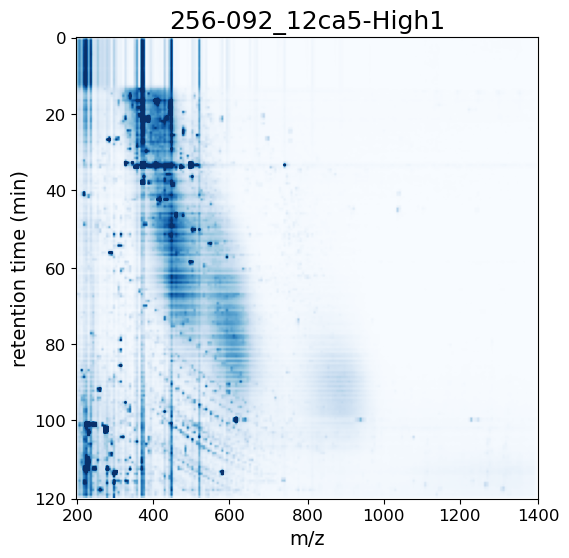

showing plot...
collecting peak data...


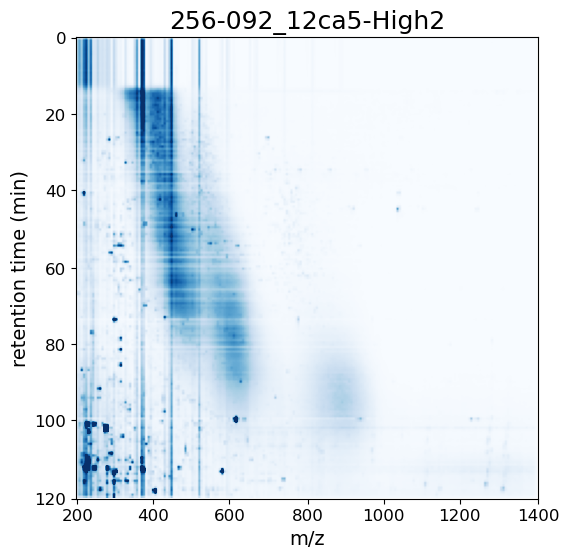

showing plot...
collecting peak data...


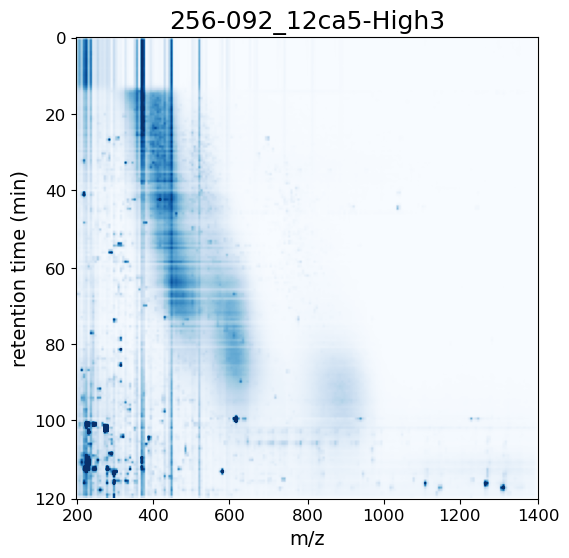

showing plot...
collecting peak data...


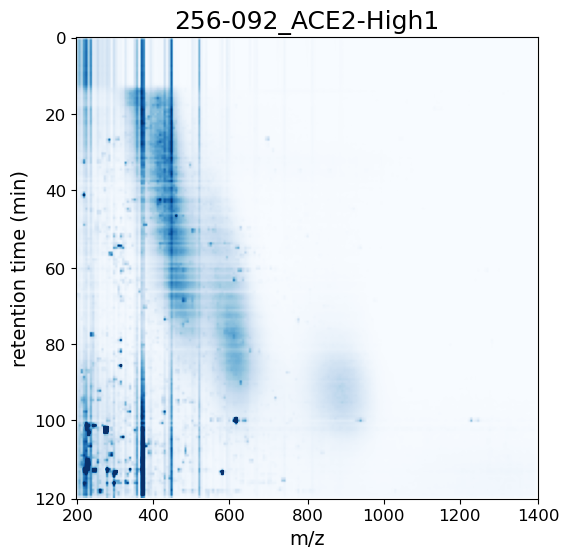

showing plot...
collecting peak data...


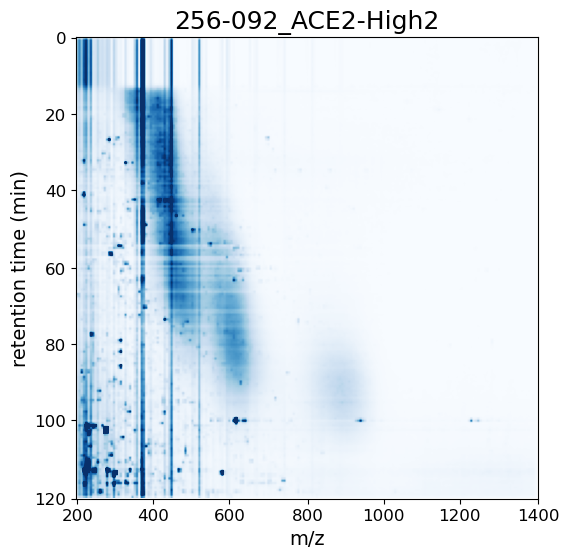

showing plot...
collecting peak data...


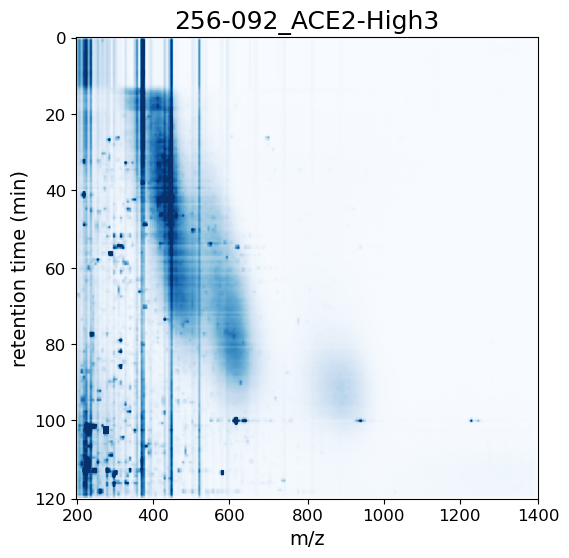

showing plot...


In [6]:
Methods.Setup().data_visualization(check_data,data_dir,png_dir,parent_dir)

## Feature Finding

In [7]:
column_names, feature_maps_full, files_all, files_path = Methods.Setup().feature_finding(data_dir,save_dir,prots)

256-092_12ca5-High1.mzML
[(b'debug', 'false'), (b'intensity:bins', 10), (b'mass_trace:mz_tolerance', 0.004), (b'mass_trace:min_spectra', 9), (b'mass_trace:max_missing', 4), (b'mass_trace:slope_bound', 0.1), (b'isotopic_pattern:charge_low', 2), (b'isotopic_pattern:charge_high', 5), (b'isotopic_pattern:mz_tolerance', 0.01), (b'isotopic_pattern:intensity_percentage', 10.0), (b'isotopic_pattern:intensity_percentage_optional', 0.1), (b'isotopic_pattern:optional_fit_improvement', 2.0), (b'isotopic_pattern:mass_window_width', 25.0), (b'isotopic_pattern:abundance_12C', 98.93), (b'isotopic_pattern:abundance_14N', 99.632), (b'seed:min_score', 0.5), (b'fit:max_iterations', 500), (b'feature:min_score', 0.5), (b'feature:min_isotope_fit', 0.8), (b'feature:min_trace_score', 0.5), (b'feature:min_rt_span', 0.333), (b'feature:max_rt_span', 3.0), (b'feature:rt_shape', 'asymmetric'), (b'feature:max_intersection', 0.35), (b'feature:reported_mz', 'monoisotopic'), (b'user-seed:rt_tolerance', 5.0), (b'user-se

[(b'debug', 'false'), (b'intensity:bins', 10), (b'mass_trace:mz_tolerance', 0.004), (b'mass_trace:min_spectra', 9), (b'mass_trace:max_missing', 4), (b'mass_trace:slope_bound', 0.1), (b'isotopic_pattern:charge_low', 2), (b'isotopic_pattern:charge_high', 5), (b'isotopic_pattern:mz_tolerance', 0.01), (b'isotopic_pattern:intensity_percentage', 10.0), (b'isotopic_pattern:intensity_percentage_optional', 0.1), (b'isotopic_pattern:optional_fit_improvement', 2.0), (b'isotopic_pattern:mass_window_width', 25.0), (b'isotopic_pattern:abundance_12C', 98.93), (b'isotopic_pattern:abundance_14N', 99.632), (b'seed:min_score', 0.5), (b'fit:max_iterations', 500), (b'feature:min_score', 0.5), (b'feature:min_isotope_fit', 0.8), (b'feature:min_trace_score', 0.5), (b'feature:min_rt_span', 0.333), (b'feature:max_rt_span', 3.0), (b'feature:rt_shape', 'asymmetric'), (b'feature:max_intersection', 0.35), (b'feature:reported_mz', 'monoisotopic'), (b'user-seed:rt_tolerance', 5.0), (b'user-seed:mz_tolerance', 1.1), (

## Feature alignment and grouping - fork between just the highest protein concentration replicates for volcano plot analysis and then all of them for fold enrichment analysis

In [8]:
original_RTs_dict, alignment_dict = Methods.Setup().feature_alignment(feature_maps_full,files_all,inj_levels[0])

In [9]:
feature_maps = []
files = []
for fm,file in zip(feature_maps_full,files_all):
    if inj_levels[0] in file and any(prot in file for prot in prots):
        feature_maps.append(fm)
        files.append(file)
    else:
        print(f'File not used for volcano plot analysis: {file}')
        
assert len(feature_maps) == n_reps*len(prots), 'Incorrect number of files found, check naming'

In [10]:
consensus_map, file_descriptions = Methods.Setup().feature_grouping(feature_maps,save_dir)

Progress of 'Linking features':
-- done [took 3.63 s (CPU), 3.67 s (Wall)] -- 
ConsensusXMLFile::store():  found 152767 invalid unique ids


In [11]:
con_feat, map_idxs, map_RTs, new_map_idxs, new_map_RTs = \
    Methods.Setup().consensus_alignment_check(consensus_map, feature_maps)

### Alignment checks, original RT extraction

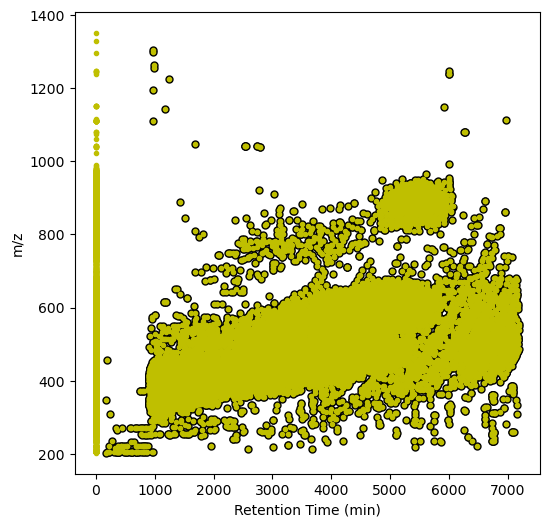

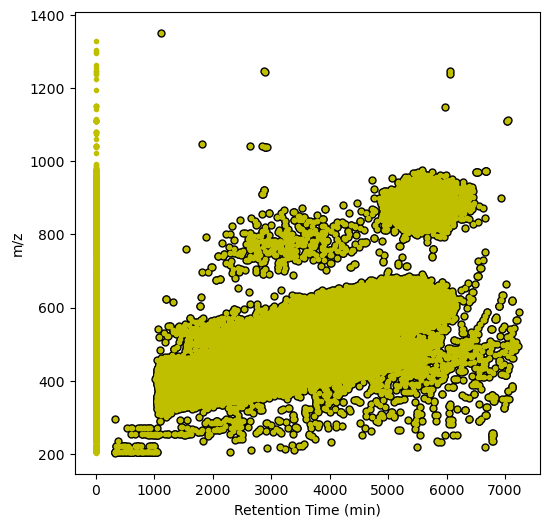

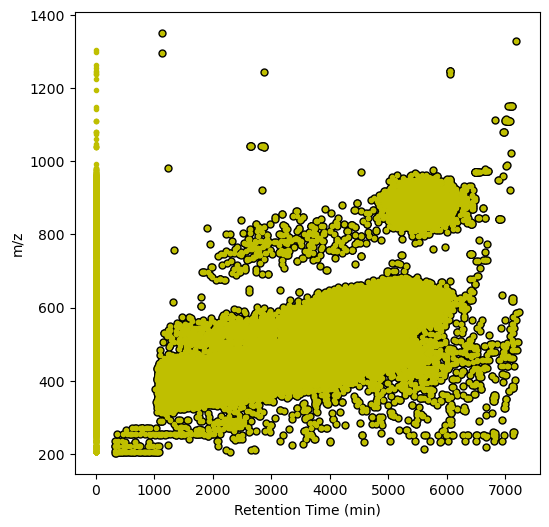

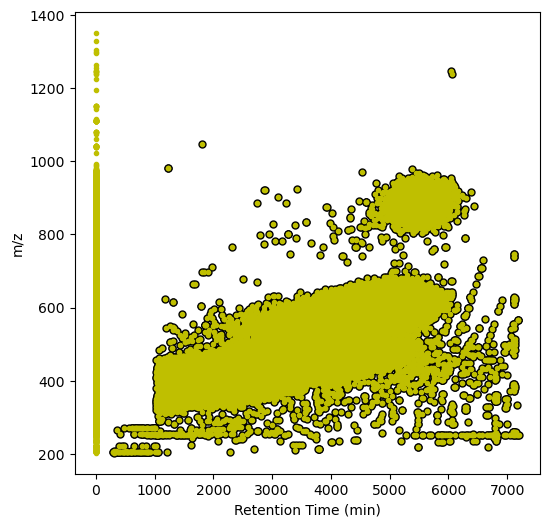

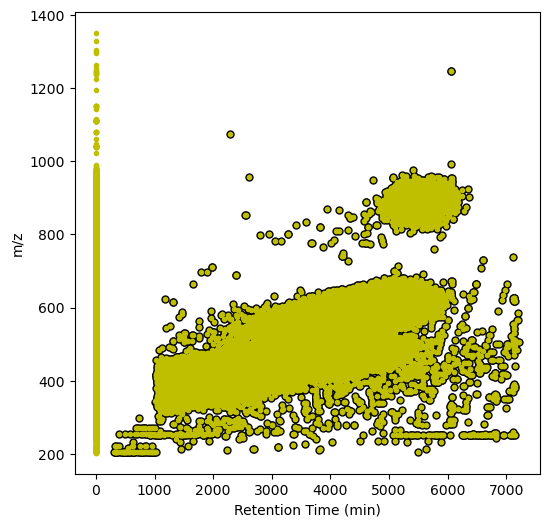

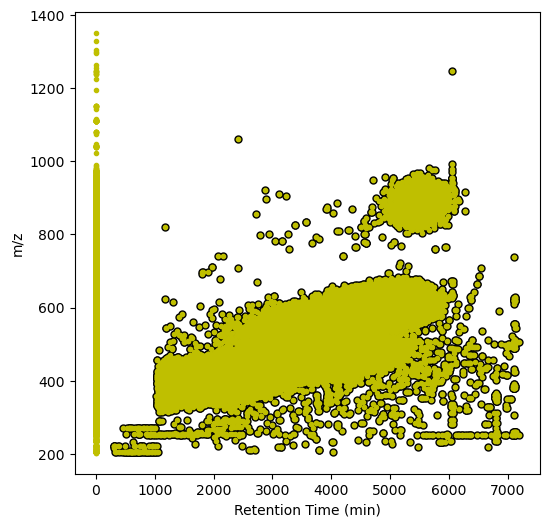

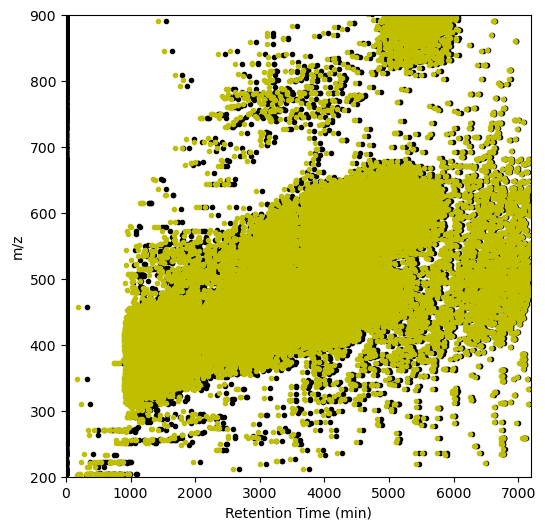

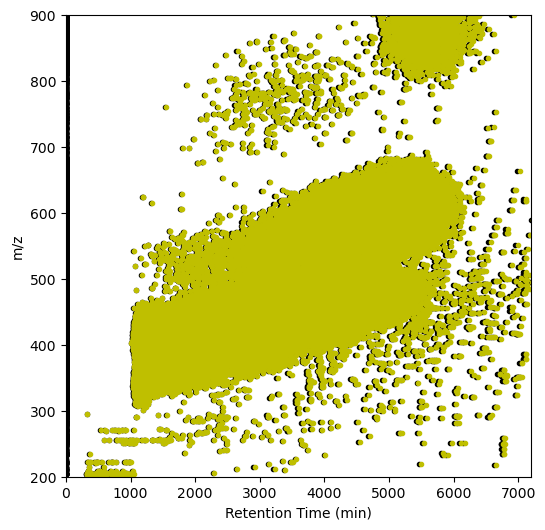

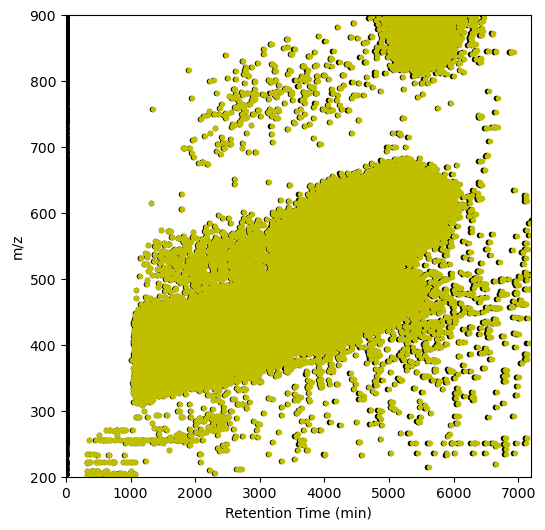

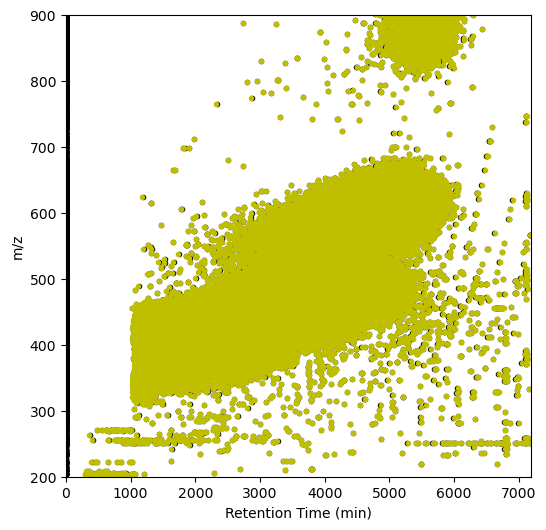

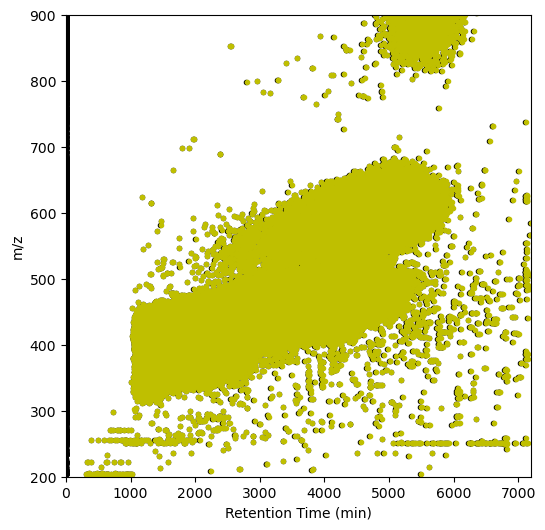

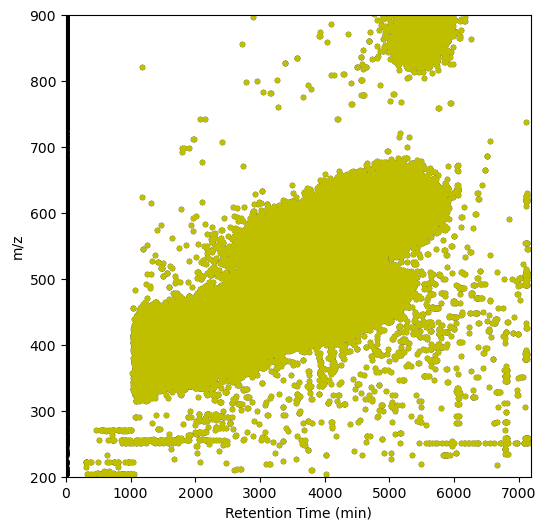

In [12]:
fixed_RT_maps_formatted = Methods.Setup().alignment_check(consensus_map,feature_maps,png_dir,
                                                          new_map_RTs,files,original_RTs_dict)

In [13]:
cf_df_final, cf_df_final_np, col_names, feat_RT_cf_combined,feat_mz_combined, \
feat_z_combined,feat_quality_combined,feat_obs_mass_combined,RTs = \
Methods.Setup().consensus_feature_details(feature_maps,con_feat,fixed_RT_maps_formatted,
                                          new_map_RTs,parent_dir,folder)
    
feat_RT_cf_combined_massfiltered,feat_RT_orig_massfiltered,feat_mz_combined_massfiltered, \
feat_z_combined_massfiltered,feat_z_combined_massfiltered,feat_quality_combined_massfiltered, \
feat_obs_mass_combined_massfiltered,RTs_massfiltered,ref_feature_mass, \
ref_feature_RT,ref_feature_RT_orig,refs_found = \
Methods.Setup().consensus_feature_details_massfilt(feat_obs_mass_combined,PRTC_mass_round,
                                                   cf_df_final_np,fixed_RT_maps_formatted,lib_size,PRTC_check)

3945 features removed due to mass out of 152766 features


In [14]:
mzs_list,RTs_list,ints_list = Methods.Calculations().get_data_volcano(data_dir,inj_levels[0],prots)

256-092_12ca5-High1
256-092_12ca5-High2
256-092_12ca5-High3
256-092_ACE2-High1
256-092_ACE2-High2
256-092_ACE2-High3


In [15]:
max_ints,rt_windows, int_windows, backgrounds = \
    Methods.Calculations().feature_int_extractor(feat_mz_combined_massfiltered,feat_RT_cf_combined_massfiltered,
                                                 feat_RT_orig_massfiltered,mzs_list,RTs_list,ints_list,
                                                 LOD=1.5E4,noise_level=1.5E4,peak_range=peak_RT_search)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000


In [16]:
peak_regular = Methods.Calculations().peak_finder_savgol(rt_windows,int_windows,prots,
                                                         plot=False,default_thresh=default_thresh,
                                                         kernal_size=3,width=5,rel_height=0.5,reps=n_reps)
peak_filtered,feat_mz_filtered,feat_RT_filtered,feat_RT_orig_filtered, \
feat_z_filtered,check_rt_windows,check_int_windows,max_ints_filtered = \
    Methods.Calculations().peak_filter_savgol(peak_regular,feat_mz_combined_massfiltered,
                                              feat_RT_cf_combined_massfiltered,feat_RT_orig_massfiltered,
                                              rt_windows,int_windows,feat_z_combined_massfiltered,max_ints)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
Features removed: 103953
Features remaining: 44868


In [17]:
areas_savgol = Methods.Calculations().feature_area_extractor_savgol(check_rt_windows,
                                                                    check_int_windows,check=False,
                                                                    mz_filtered = feat_mz_filtered,
                                                                    RT_filtered = feat_RT_filtered, width_start=10,
                                                                    prominence=2,threshold=10,rel_height=0.85,
                                                                    area_baseline = area_limit, peak_RT = peak_RT)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000


In [18]:
selectivity,selectivity_intstd,pvals,specifics,spec_label = \
    Methods.Calculations().selectivity_scoring(areas_savgol,1,prots,prots,reps=n_reps,p_score_cutoff=p_score_cutoff)

Moving on to stats
Moving on to scoring


In [19]:
if not do_second_filter:
    feat_mz_filtered = feat_mz_combined_massfiltered
    feat_RT_filtered = feat_RT_cf_combined_massfiltered
    feat_z_filtered = feat_z_combined_massfiltered
    max_ints_filtered = max_ints

## Selectivity Results

In [20]:
sels_graphing,sels_graphing_intstd,ps_graphing,RTs_graphing,RTs_graphing_orig, \
mzs_graphing,z_graphing,areas_graphing,sels_nonspecific,sels_nonspecific_intstd, \
ps_nonspecific,RTs_nonspecific,RTs_nonspecific_orig,mzs_nonspecific,z_nonspecific, \
areas_nonspecific, sels_unclear,sels_unclear_intstd,ps_unclear,RTs_unclear, \
RTs_unclear_orig,mzs_unclear,z_unclear,areas_unclear = \
    Methods.Calculations().setup_output(prots,spec_label,selectivity,selectivity_intstd,
                                        pvals,feat_RT_filtered,feat_RT_orig_filtered,feat_mz_filtered,
                                        feat_z_filtered,areas_savgol)

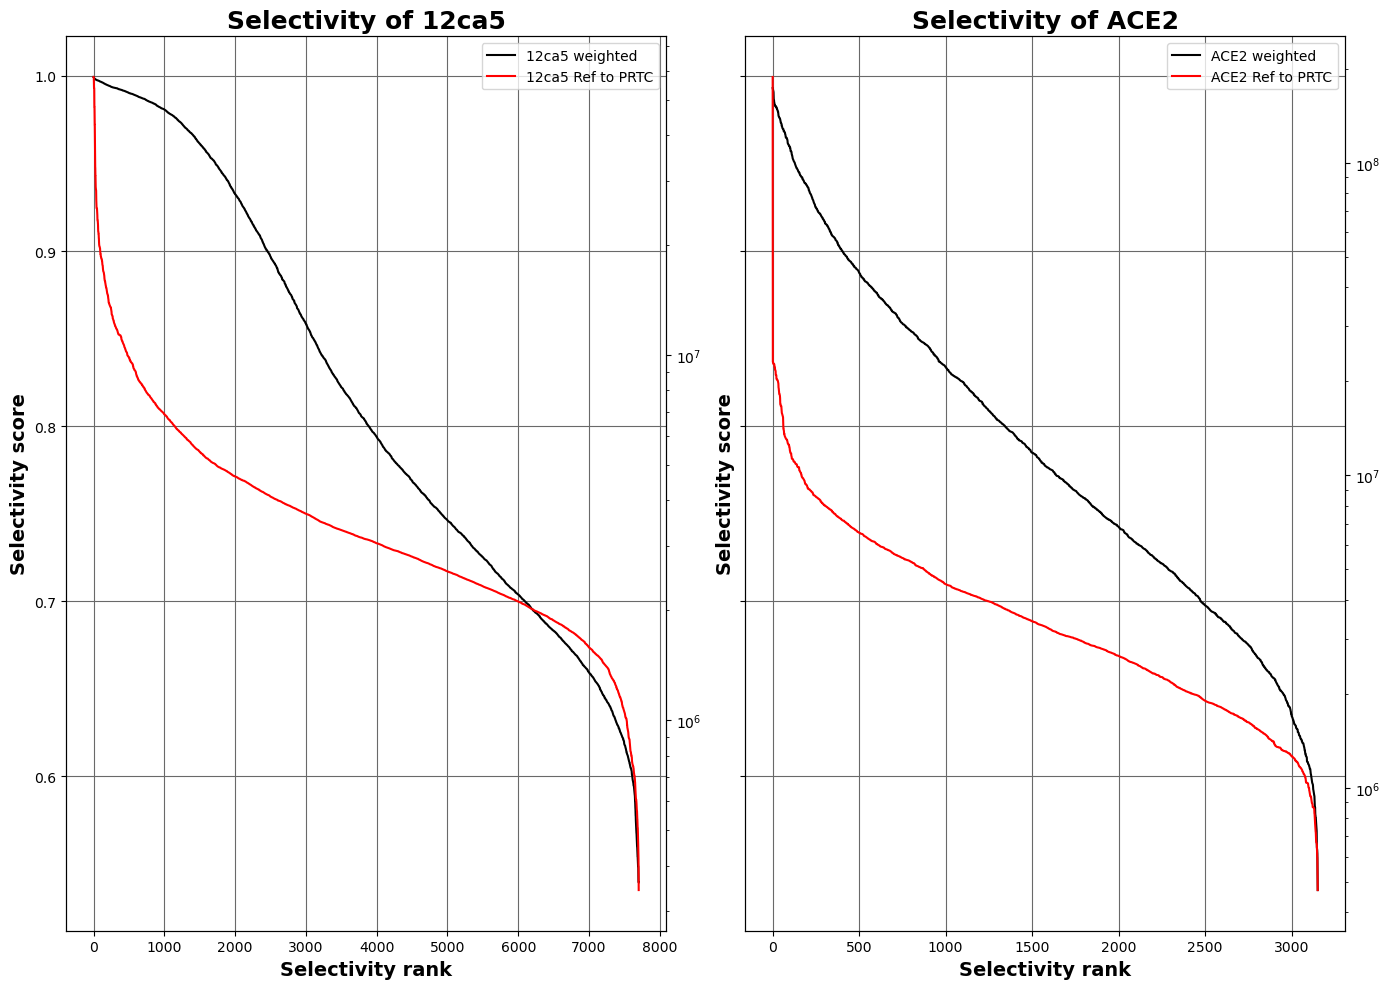

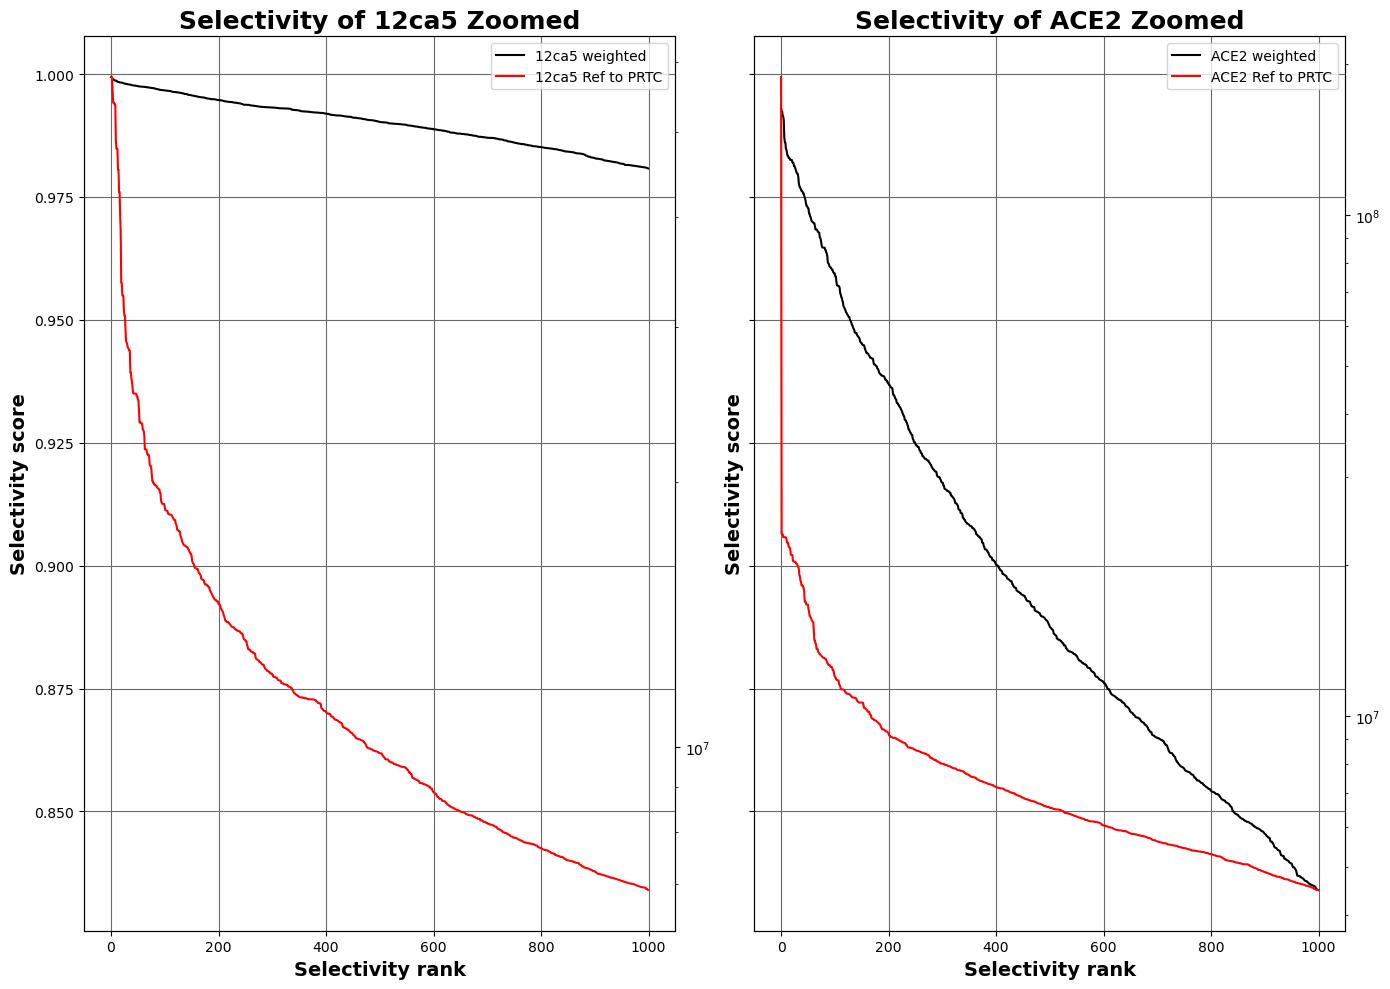

In [21]:
Methods.Calculations().selectivity_rankings(prots,sels_graphing,sels_graphing_intstd,results_dir)

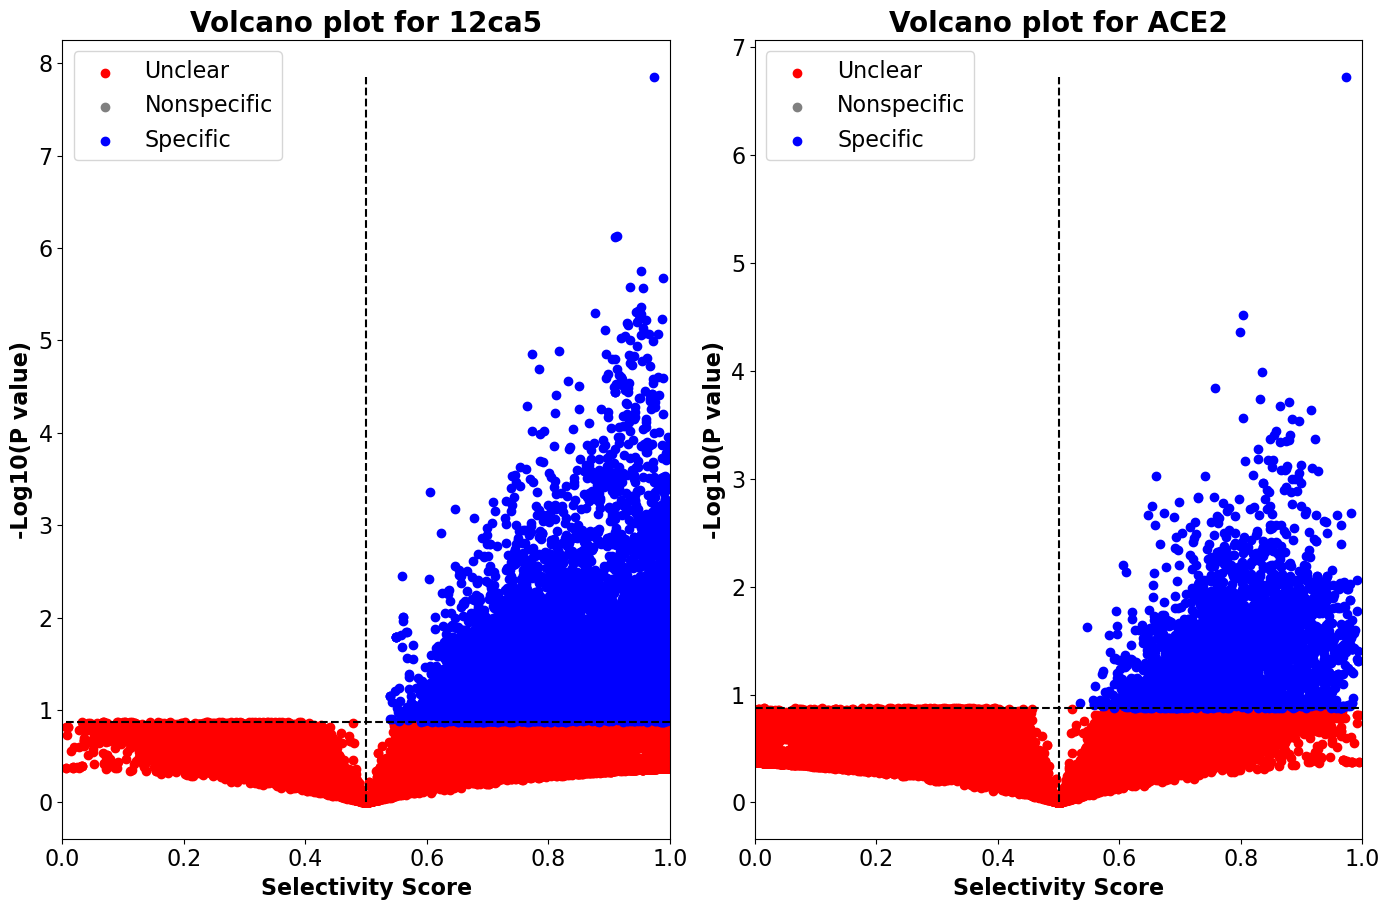

In [22]:
Methods.Calculations().volcano_plotting(prots,sels_graphing,sels_nonspecific,sels_unclear,
                                        ps_graphing,ps_nonspecific,ps_unclear,feat_mz_combined,
                                        selectivity,p_score_cutoff,sel_cutoff,results_dir)

In [23]:
Methods.Report_results().export_results(selectivity,sels_graphing,RTs_graphing,mzs_graphing,ps_graphing,
                                        z_graphing,sel_cutoff,p_score_cutoff,prots,results_dir,misc_dir,
                                        feat_RT_filtered,feat_mz_filtered,feat_z_filtered,pvals,
                                        spec_label,areas_savgol,full_out)

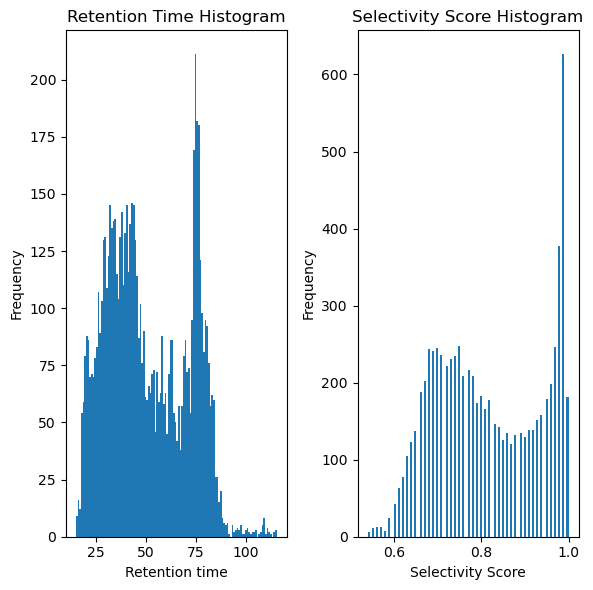

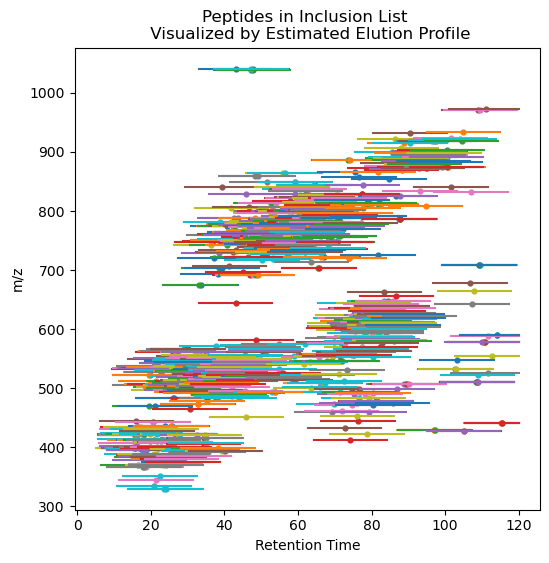

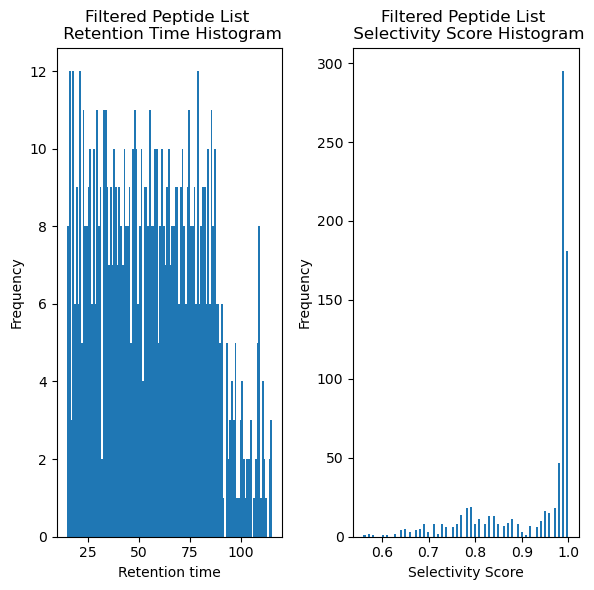

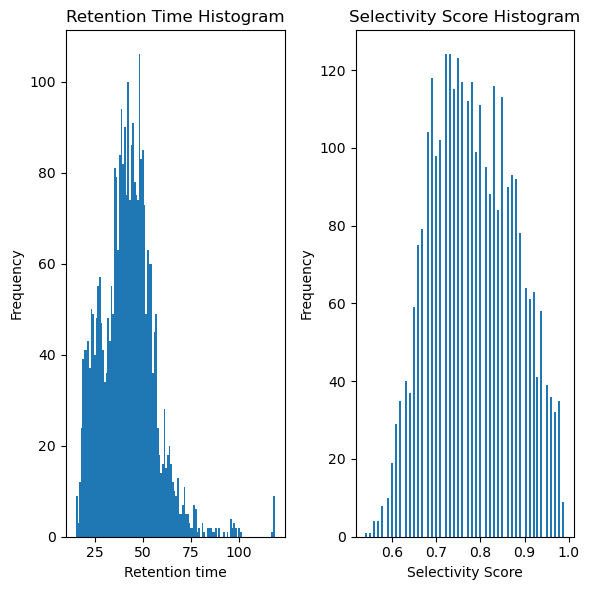

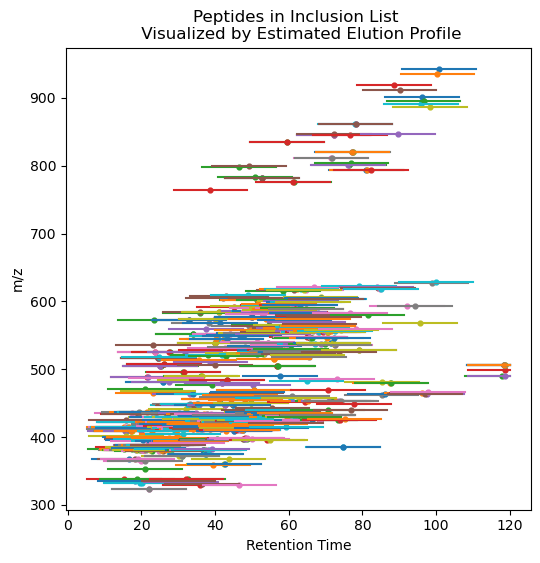

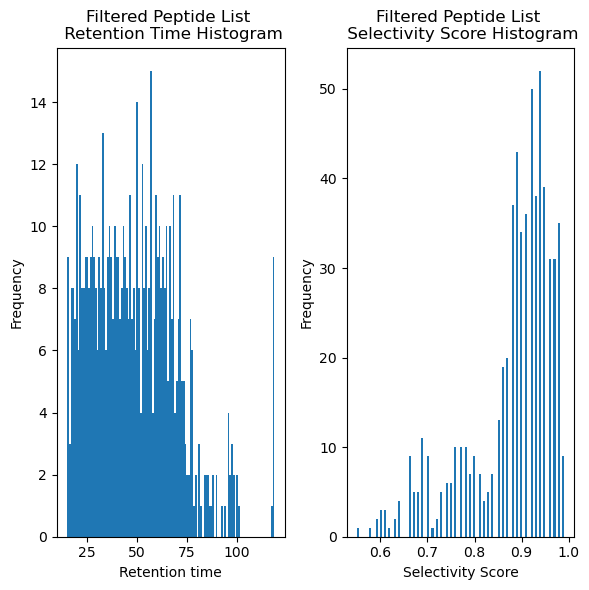

In [24]:
Methods.Report_results().inclusion_lists(parent_dir,results_dir,misc_dir,folder,prots,gradient_time,peps_min,
                                         RT_start = RT_start, RT_window = elute_window, variable_loading = variable_loading)

In [25]:
Methods.Report_results().inclusion_areascorefiltered(sels_graphing,RTs_graphing,RTs_graphing_orig,mzs_graphing,
                                                     ps_graphing,z_graphing,areas_graphing,sel_cutoff,
                                                     p_score_cutoff,prots,misc_dir,n_reps,area_limit,
                                                     sel_minqual,gradient_time,variable_loading)

In [26]:
if sub_EICs:
    eicdir = Methods.Report_results().inclusion_areascorefiltered_excel(parent_dir,results_dir,misc_dir,prots,
                                                                        inj_levels[0],num=nr_EICs,reps=n_reps,
                                                                        RT_start=RT_start, elute_window=elute_window)

## Concentration-Dependent Enrichment Analysis

In [27]:
if variable_loading:
    mzs_list_CDE,RTs_list_CDE,ints_list_CDE, files_CDE = Methods.Calculations().get_data(data_dir,prots + [refname],
                                                                             inj_levels = inj_levels, 
                                                                             refname = refname)

    max_ints_CDE,rt_windows_CDE, int_windows_CDE, backgrounds_CDE = \
        Methods.Calculations().feature_int_extractor_average(feat_mz_filtered,
                                                     feat_RT_filtered,
                                                     mzs_list_CDE,RTs_list_CDE,ints_list_CDE,
                                                     LOD=1.5E4,noise_level=1.5E4,peak_range=peak_RT_search)

    areas_savgol_CDE = Methods.Calculations().feature_area_extractor_savgol(rt_windows_CDE,
                                                                        int_windows_CDE,check=False,
                                                                        mz_filtered = feat_mz_filtered,
                                                                        RT_filtered = feat_RT_filtered,
                                                                        width_start=10,
                                                                        prominence=2,threshold=10,rel_height=0.85,
                                                                        area_baseline = area_limit, peak_RT=peak_RT)

In [28]:
if variable_loading:
    areas_by_prot, yints_by_prot, slopes_combined, ave_area_ref = Methods.Conc_Dep_Enrichment().setup_CDE(areas_savgol_CDE,
                                                                    files_CDE,prots,inj_levels,inj_percs,1,
                                                                    refname = refname)
    outputdir, all_slope_abs, fig_refs = Methods.Conc_Dep_Enrichment().CDE_report_excel(areas_by_prot,
                                                                        yints_by_prot, ave_area_ref,
                                                                        slopes_combined,feat_mz_filtered,
                                                                        feat_RT_filtered,feat_z_filtered,
                                                                        results_dir,misc_dir,prots,
                                                                        num = nr_EICs,decimal = 4)

In [29]:
if variable_loading: Methods.Conc_Dep_Enrichment().plot_cde_ranking(prots,all_slope_abs,results_dir)

# Now Combine Selectivity and Concentration-Dependent Enrichment

In [30]:
if variable_loading: 
    Methods.Conc_Dep_Enrichment().selscore_vs_cde(prots,selectivity,selectivity_intstd,all_slope_abs,
                                       results_dir, sel_cutoff = sel_cutoff)

In [31]:
if variable_loading:
    Methods.Conc_Dep_Enrichment().cde_vs_pval(prots,all_slope_abs,pvals,
                                              results_dir,p_score_cutoff = p_score_cutoff)

In [32]:
if variable_loading:
    Methods.Conc_Dep_Enrichment().pval_vs_cde_vs_selscore(prots,pvals,all_slope_abs,
                                                          selectivity,results_dir,intstd = False)

In [33]:
if variable_loading: 
    df_ranking = Methods.Report_results().combined_result_export(feat_mz_filtered,feat_RT_filtered,feat_z_filtered,
                                                                 spec_label,pvals,selectivity,
                                                                 selectivity_intstd,all_slope_abs,slopes_combined,
                                                                 areas_by_prot,yints_by_prot,
                                                                 ave_area_ref,prots,misc_dir)

In [34]:
if variable_loading: 
    eicdir, dfs_by_prot = Methods.Report_results().combined_result_EICs(df_ranking,parent_dir,
                                              results_dir, misc_dir,prots,
                                              num = nr_EICs, reps = n_reps,RT_start = RT_start, 
                                              elute_window = elute_window, gradient_time = gradient_time,
                                              sortby_selscore = sortby_selscore)

    for df_sub,prot in zip(dfs_by_prot,prots):
        Methods.Report_results().final_inclusion_lists(df_sub,parent_dir,results_dir,misc_dir,
                                                    folder,prot,gradient_time,peps_min,RT_start=RT_start,
                                                    RT_window = elute_window, intstd = False)